### Paquetes a Importar

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.datasets import mnist, fashion_mnist
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from joblib import dump, load
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential, load_model
from lime import lime_image
from skimage.segmentation import mark_boundaries
from skimage.color import gray2rgb
import os
import shap
import pickle

C:\Users\MATIA\anaconda3\envs\tfi_especializacion\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Preprocesamiento de los Datos

### Cargar los Datasets

In [2]:
# Cargar el dataset MNIST
(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = mnist.load_data()

# Cargar el dataset Fashion MNIST
(x_train_fashion, y_train_fashion), (x_test_fashion, y_test_fashion) = fashion_mnist.load_data()


### Normalización de los Datos

Es una buena práctica normalizar los datos de entrada para que los valores de los píxeles estén en el rango de 0 a 1. Esto ayuda a mejorar el entrenamiento del modelo al mantener los valores de entrada pequeños.

In [3]:
x_train_mnist, x_test_mnist = x_train_mnist / 255.0, x_test_mnist / 255.0
x_train_fashion, x_test_fashion = x_train_fashion / 255.0, x_test_fashion / 255.0

### Visualización de las Imágenes

In [4]:
def plot_images(images, labels, indices, title, color='bone'):
    # Calcula el número de imágenes
    n_images = len(indices)

    # Determina las filas y columnas basadas en la cantidad de imágenes
    rows = int(np.sqrt(n_images))
    cols = n_images // rows if n_images % rows == 0 else n_images // rows + 1

    # Configura la figura
    fig = plt.figure(figsize=(cols*2, rows*2))
    fig.suptitle(title, fontsize=16)
    # Itera sobre el número de índices y muestra las imágenes correspondientes
    for i, idx in enumerate(indices):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.set_title(f"Label: {labels[idx]}")
        ax.imshow(images[idx], cmap="bone")
        ax.axis('off')
    plt.show()


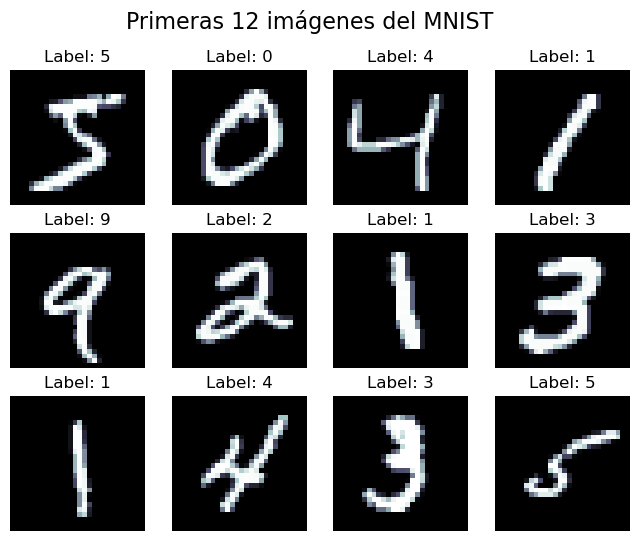

In [5]:
cant = 12
indices = list(range(0, cant, 1))
plot_images(x_train_mnist,y_train_mnist, indices,"Primeras " +str(cant)+ " imágenes del MNIST")

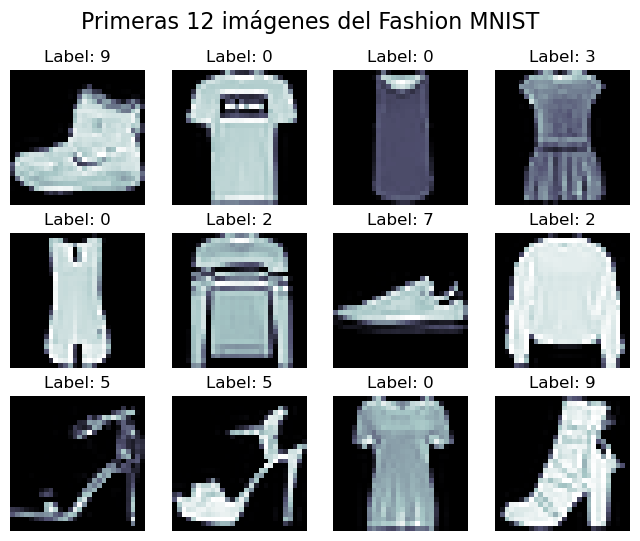

In [6]:
plot_images(x_train_fashion,y_train_fashion, indices, "Primeras " +str(cant)+ " imágenes del Fashion MNIST")

## Contar las ocurrencias de cada etiqueta en el conjunto de entrenamiento

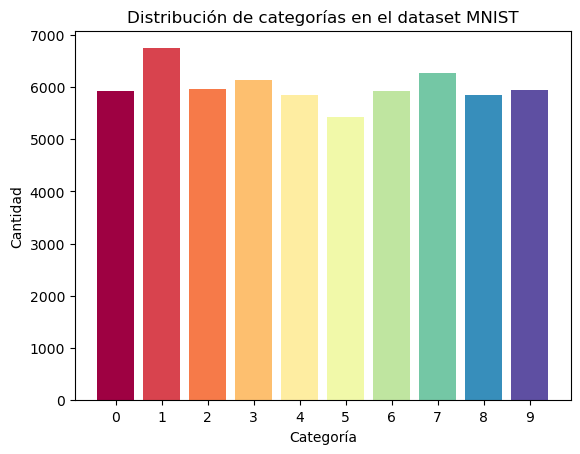

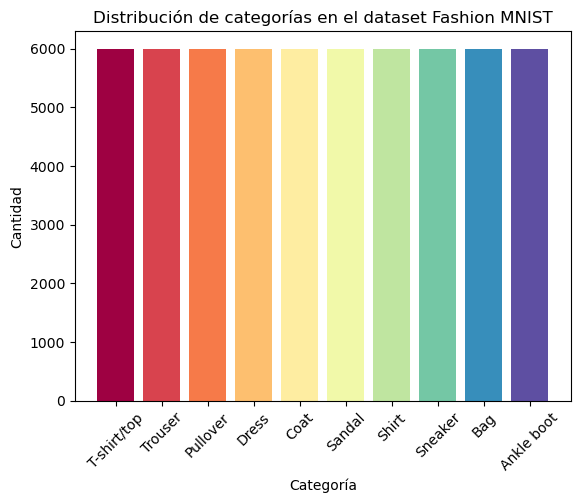

In [7]:
def plot_category_distribution(labels, title, category_names=None):
    # Calcula la cantidad de cada categoría
    unique, counts = np.unique(labels, return_counts=True)
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique)))
    # Configura la figura
    fig, ax = plt.subplots()
    ax.bar(unique, counts, color=colors)
    ax.set_xticks(unique)
    if category_names:
        ax.set_xticklabels([category_names[i] for i in unique], rotation=45)
    else:
        ax.set_xticklabels(unique)
    ax.set_title(title)
    ax.set_xlabel('Categoría')
    ax.set_ylabel('Cantidad')
    plt.show()

# Ejemplo de uso con el dataset MNIST
plot_category_distribution(y_train_mnist, 'Distribución de categorías en el dataset MNIST')

# Ejemplo de uso con el dataset Fashion MNIST
fashion_mnist_labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", 
                        "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
plot_category_distribution(y_train_fashion, 'Distribución de categorías en el dataset Fashion MNIST', fashion_mnist_labels)

## Preparación de los Datos
Considerando que los modelos esperan vectores en lugar de imágenes, aplanaré las imágenes para que queden en forma de vectores

In [8]:
# Aplanar las imágenes para modelos de caja blanca
x_train_mnist_flat = x_train_mnist.reshape((x_train_mnist.shape[0], -1))
x_test_mnist_flat = x_test_mnist.reshape((x_test_mnist.shape[0], -1))
x_train_fashion_flat = x_train_fashion.reshape((x_train_fashion.shape[0], -1))
x_test_fashion_flat = x_test_fashion.reshape((x_test_fashion.shape[0], -1))

# Modelos de Aprendizaje Automático

## Registro de los modelos

Utilizaré un DataFrame, para almacenar los resultados de ejecución de cada modelo durante su ejecución, y otro con las predicciones

In [9]:
resultados = pd.DataFrame(columns=['Dataset', 'Modelo','Descripcion', 'Accuracy'])
predicciones = {}

## Evaluación de los Modelos
Para garantizar un código eficiente y fácil de mantener en mi proyecto de análisis de modelos de aprendizaje automático, desarrollé una función genérica denominada `evaluate_model`. Esta función me permite evaluar cualquier modelo de clasificación y visualizar sus resultados de manera estandarizada. Su propósito es realizar predicciones con el modelo proporcionado, generar un reporte de clasificación detallado y visualizar una matriz de confusión.

La función `evaluate_model` recibe varios argumentos: el modelo entrenado (`model`), los datos de prueba (`X_test`), las etiquetas reales de los datos de prueba (`y_test`), un nombre descriptivo para el modelo (`model_name`), y el nombre del conjunto de datos (`dataset_name`). Con estos inputs, la función ejecuta el siguiente proceso:

* **Predicción**: Utiliza el modelo para predecir las etiquetas de los datos de prueba.
* **Reporte de Clasificación**: Calcula y muestra un informe de clasificación utilizando `classification_report` de scikit-learn, que proporciona métricas como precisión, recall y f1-score por clase, lo cual es crucial para entender el rendimiento del modelo en detalle.
* **Matriz de Confusión**: Genera y visualiza una matriz de confusión usando la biblioteca `seaborn`. Esta matriz es esencial para visualizar cómo las predicciones se comparan con las etiquetas reales, permitiéndome identificar rápidamente las clases que el modelo predice correctamente y aquellas donde se equivoca.

Además esta función retorna los valores predichos, por si es necesario utilziar posteriormente

In [10]:
def evaluate_model(model, X_test, y_test, model_name, dataset_name, viz = True):
    """
    Función para evaluar un modelo y visualizar la matriz de confusión.
    Args:
    - model: modelo entrenado
    - X_test: datos de prueba (features)
    - y_test: etiquetas reales de los datos de prueba
    - model_name: nombre del modelo (para títulos)
    - dataset_name: nombre del dataset (para títulos)
    """
    # Predicción con el modelo
    predictions = model.predict(X_test)

    if(model_name == "DNN" or model_name == "CNN"):
        predictions = np.argmax(predictions, axis=1)
    if(viz):
        # Generar el reporte de clasificación
        report = classification_report(y_test, predictions)
        print(f"Reporte de Clasificación para el Modelo: {model_name} sobre el DataSet: {dataset_name}:\n{report}")
        
        # Crear y visualizar la matriz de confusión
        cm = confusion_matrix(y_test, predictions)
        plt.figure(figsize=(7, 7))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f"Matriz de Confusión para el Modelo: {model_name} sobre el DataSet: {dataset_name}")
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.tight_layout()
        plt.show()
    
    acc = accuracy_score(y_test, predictions)
    # Crear un DataFrame con los resultados de esta ejecución
    resultados_nuevos = pd.DataFrame({'Dataset': [dataset_name], 'Modelo': [model_name],'Descripcion': [model], 'Accuracy': [acc]})

    # Guardar los resultados en el DataFrame global
    global resultados
    
    resultados = pd.concat([resultados, resultados_nuevos], ignore_index=True)

    return predictions

En caso de ya tener los modelos ejecutados y almacenados, dirigirse a la sección de __Carga de modelos almacenados__

## Modelos de Caja Blanca

### Regresión Logística

#### Crear y entrenar el modelo de Regresión Logística para MNIST

In [73]:
logreg_mnist = LogisticRegression(max_iter=1000,random_state=42)
logreg_mnist.fit(x_train_mnist_flat, y_train_mnist)

LogisticRegression(max_iter=1000, random_state=42)

In [74]:
dump(logreg_mnist, 'logreg_mnist.joblib')

['logreg_mnist.joblib']

#### Crear y entrenar el modelo de Regresión Logística para Fashion MNIST

In [75]:
logreg_fashion = LogisticRegression(max_iter=1000,random_state=42)
logreg_fashion.fit(x_train_fashion_flat, y_train_fashion)

LogisticRegression(max_iter=1000, random_state=42)

In [76]:
dump(logreg_fashion, 'logreg_fashion.joblib')

['logreg_fashion.joblib']

#### Uso de la función `evaluate_model` para cada modelo y dataset

Reporte de Clasificación para el Modelo: Regresión Logística sobre el DataSet: MNIST:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       980
           1       0.96      0.98      0.97      1135
           2       0.93      0.90      0.91      1032
           3       0.90      0.91      0.91      1010
           4       0.94      0.94      0.94       982
           5       0.90      0.87      0.88       892
           6       0.94      0.95      0.95       958
           7       0.93      0.92      0.93      1028
           8       0.89      0.88      0.88       974
           9       0.91      0.92      0.91      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



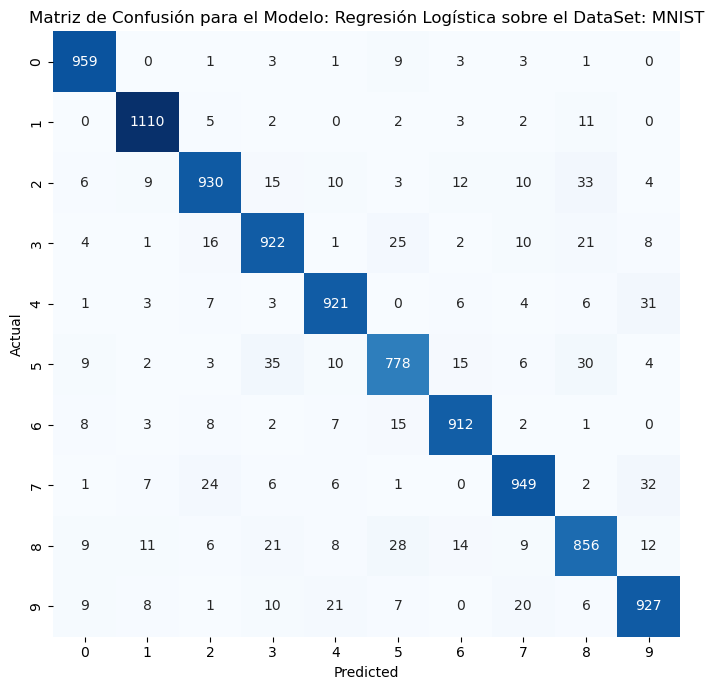

In [77]:
y_pred_mnist_log_reg = evaluate_model(logreg_mnist, x_test_mnist_flat, y_test_mnist, "Regresión Logística", "MNIST")

Reporte de Clasificación para el Modelo: Regresión Logística sobre el DataSet: Fashion MNIST:
              precision    recall  f1-score   support

           0       0.80      0.81      0.80      1000
           1       0.97      0.96      0.96      1000
           2       0.72      0.74      0.73      1000
           3       0.83      0.86      0.84      1000
           4       0.74      0.76      0.75      1000
           5       0.95      0.92      0.93      1000
           6       0.62      0.57      0.60      1000
           7       0.91      0.94      0.93      1000
           8       0.93      0.94      0.93      1000
           9       0.95      0.95      0.95      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



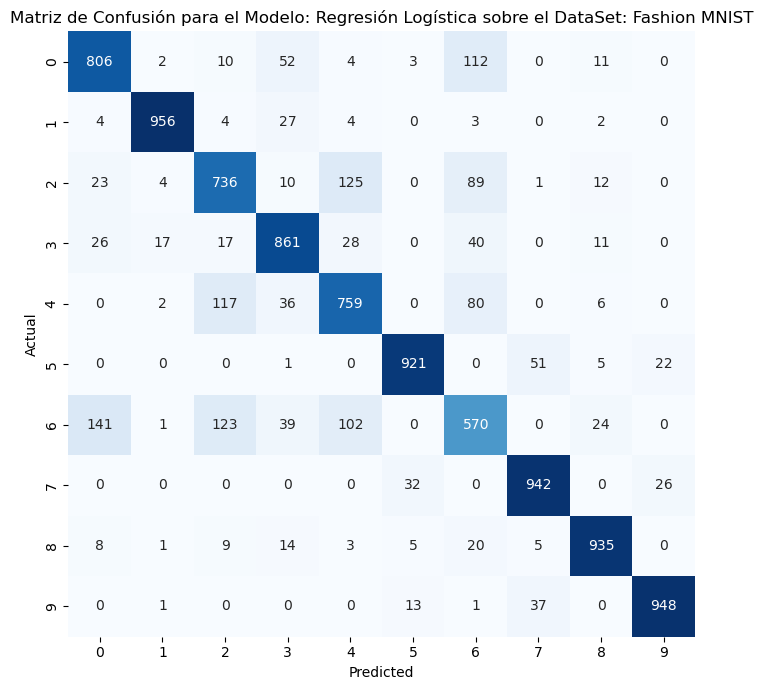

In [78]:
y_pred_mnistfashion_log_reg = evaluate_model(logreg_fashion, x_test_fashion_flat, y_test_fashion, "Regresión Logística", "Fashion MNIST")

In [233]:
predicciones['logreg_mnist'] = y_pred_mnist_log_reg
predicciones['logreg_fashion'] = y_pred_mnistfashion_log_reg

### Árbol de Decisión

#### Crear y entrenar el modelo de Árbol de Decisión para MNIST

In [237]:
tree_mnist = DecisionTreeClassifier(random_state=42)
tree_mnist.fit(x_train_mnist_flat, y_train_mnist)

DecisionTreeClassifier(random_state=42)

In [60]:
dump(tree_mnist, 'tree_mnist.joblib')

['tree_mnist.joblib']

#### Crear y entrenar el modelo de Árbol de Decisión para Fashion MNIST

In [238]:
tree_fashion = DecisionTreeClassifier(random_state=42)
tree_fashion.fit(x_train_fashion_flat, y_train_fashion)

DecisionTreeClassifier(random_state=42)

In [59]:
dump(tree_fashion, 'tree_fashion.joblib')

['tree_fashion.joblib']

#### Uso de la función `evaluate_model` para cada modelo y dataset

Reporte de Clasificación para el Modelo: Árbol de Decisión sobre el DataSet: MNIST:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       980
           1       0.95      0.96      0.95      1135
           2       0.86      0.86      0.86      1032
           3       0.83      0.85      0.84      1010
           4       0.86      0.87      0.87       982
           5       0.85      0.83      0.84       892
           6       0.90      0.88      0.89       958
           7       0.91      0.90      0.91      1028
           8       0.82      0.81      0.81       974
           9       0.85      0.85      0.85      1009

    accuracy                           0.88     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.88      0.88      0.88     10000



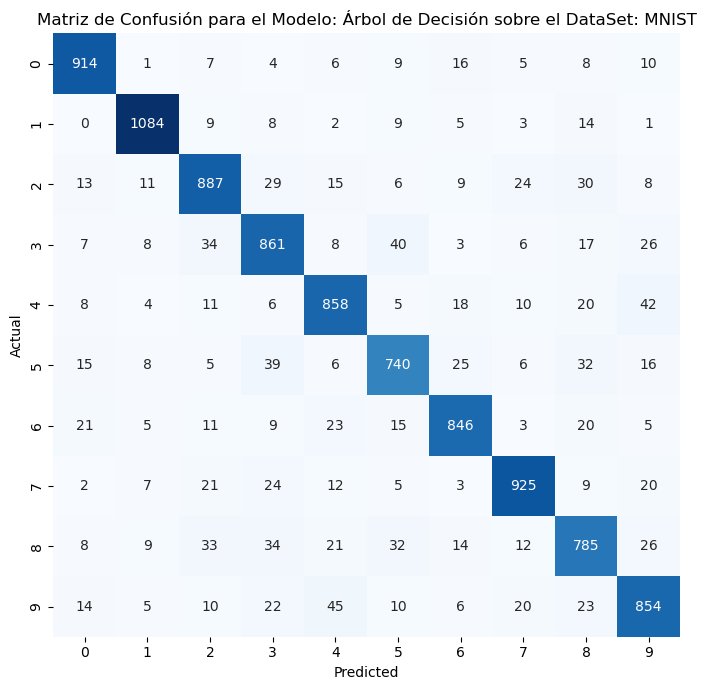

In [239]:
y_pred_mnist_tree = evaluate_model(tree_mnist, x_test_mnist_flat, y_test_mnist, "Árbol de Decisión", "MNIST")

Reporte de Clasificación para el Modelo: Árbol de Decisión sobre el DataSet: Fashion MNIST:
              precision    recall  f1-score   support

           0       0.76      0.73      0.74      1000
           1       0.96      0.95      0.95      1000
           2       0.63      0.65      0.64      1000
           3       0.82      0.79      0.80      1000
           4       0.64      0.63      0.64      1000
           5       0.90      0.89      0.89      1000
           6       0.52      0.55      0.53      1000
           7       0.87      0.88      0.88      1000
           8       0.91      0.91      0.91      1000
           9       0.90      0.91      0.91      1000

    accuracy                           0.79     10000
   macro avg       0.79      0.79      0.79     10000
weighted avg       0.79      0.79      0.79     10000



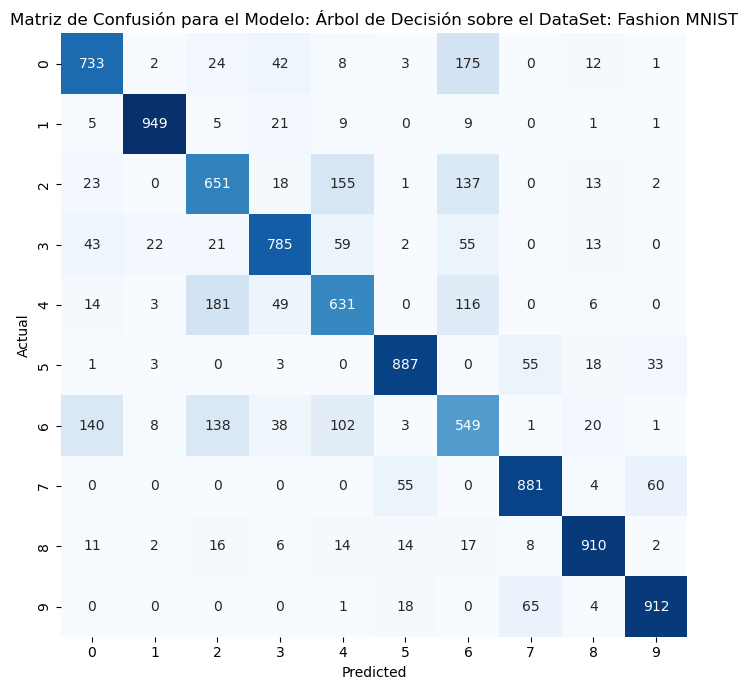

In [240]:
y_pred_mnistfashion_tree = evaluate_model(tree_fashion, x_test_fashion_flat, y_test_fashion, "Árbol de Decisión", "Fashion MNIST")

In [241]:
predicciones['tree_mnist'] = y_pred_mnist_tree
predicciones['tree_fashion'] = y_pred_mnistfashion_tree

### Accuracy de los dos modelos para cada DataSet

#### MNIST

In [34]:
accuracy_log_reg_mnist = accuracy_score(y_test_mnist, y_pred_mnist_log_reg)
accuracy_tree_mnist = accuracy_score(y_test_mnist, y_pred_mnist_tree)
print("Accuracy de Regresión Logística en MNIST: ", accuracy_log_reg_mnist*100)
print("Accuracy de Árbol de Decisión en MNIST: ", accuracy_tree_mnist*100)

Accuracy de Regresión Logística en MNIST:  92.64
Accuracy de Árbol de Decisión en MNIST:  87.53999999999999


In [33]:
accuracy_log_reg_fashion = accuracy_score(y_test_fashion, y_pred_mnistfashion_log_reg)
accuracy_tree_fashion = accuracy_score(y_test_fashion, y_pred_mnistfashion_tree)
print("Accuracy de Regresión Logística en Fashion MNIST: ", accuracy_log_reg_fashion*100)
print("Accuracy de Árbol de Decisión en Fashion MNIST: ", accuracy_tree_fashion*100)

Accuracy de Regresión Logística en Fashion MNIST:  84.34
Accuracy de Árbol de Decisión en Fashion MNIST:  78.88


### Análisis de Modelos de Caja Blanca en MNIST y Fashion MNIST

#### Resultados en MNIST

- **Regresión Logística**:
  - Precisión alcanzada: **92.64%**
  - Comentarios: La precisión lograda con este modelo lineal simple es indicativa de su adecuación para clasificar los dígitos escritos a mano en MNIST, sugiriendo que las características lineales son suficientes para capturar diferencias clave entre las clases.

- **Árbol de Decisión**:
  - Precisión alcanzada: **87.54%**
  - Comentarios: Esta precisión, aunque razonablemente alta, es menor que la obtenida con la Regresión Logística. Esto podría deberse a un posible sobreajuste o a una incapacidad para manejar adecuadamente la dimensionalidad de las imágenes, lo que lleva a un rendimiento inferior, teniendo en cuenta que no se realizó ajuste de los hiperparámetros del árbol.

#### Resultados en Fashion MNIST

- **Regresión Logística**:
  - Precisión alcanzada: **84.34%**
  - Comentarios: A pesar de la complejidad visual y la variabilidad sutil entre categorías de ropa, la Regresión Logística demostró ser bastante robusta, proporcionando un buen rendimiento general. Esto destaca su utilidad incluso en contextos más complejos.

- **Árbol de Decisión**:
  - Precisión alcanzada: **78.88%**
  - Comentarios: Este es el rendimiento más bajo entre los modelos evaluados, resaltando las dificultades del Árbol de Decisión para procesar eficientemente la alta dimensionalidad y complejidad de Fashion MNIST, teniendo en cuenta que no se realizó ajuste de los hiperparámetros del árbol.

#### Reflexiones Generales

Mis análisis muestra que la **Regresión Logística** superó consistentemente al **Árbol de Decisión** en ambas tareas de clasificación de imágenes. Este resultado refuerza la idea de que, para datos de imagen, modelos lineales bien ajustados pueden ser más efectivos y robustos en comparación con métodos basados en árboles que tienden a sobreajustarse. Dada la superioridad mostrada por la Regresión Logística, continuo interesado en explorar otros modelos que puedan ofrecer una mayor precisión y robustez, especialmente para desafíos como el presentado por Fashion MNIST.


## Modelos de Caja Negra

En esta sección me centraré en el desarrollo y evaluación de modelos de aprendizaje automático conocidos como "caja negra". Estos modelos, a diferencia de los de "caja blanca" que son más interpretables directamente, suelen ser más complejos y menos transparentes en cuanto a cómo llegan a sus decisiones. Los modelos de caja negra que planeo explorar incluyen Máquinas de Soporte Vectorial (SVM), RandomForest, Redes Neuronales utilizando MLPClassifier, Redes Neuronales Profundas (DNN) y Redes Neuronales Convolucionales (CNN) construidas con librerías avanzadas como TensorFlow o Keras.

El objetivo de utilizar estos modelos es aprovechar su capacidad para manejar patrones complejos y grandes volúmenes de datos, lo cual es crucial para desafíos como los presentados por los datasets MNIST y Fashion MNIST. Comenzaré con implementaciones básicas de cada modelo para establecer una línea base de rendimiento. Posteriormente, ajustaré los hiperparámetros y exploraré configuraciones más complejas para optimizar su eficacia.

Una vez que estos modelos estén implementados y evaluados, mi siguiente paso será aplicar técnicas de explicabilidad agnóstica al modelo. Esto es esencial para poder entender y comunicar cómo estas cajas negras hacen sus predicciones, lo cual es crucial tanto desde una perspectiva ética como práctica, especialmente en campos donde las decisiones automatizadas deben ser justificables y transparentes.

Este enfoque no solo me permitirá demostrar la potencia de estos modelos avanzados en tareas de clasificación de imágenes, sino que también explorará hasta qué punto podemos hacer que estos modelos opacos sean comprensibles y sus decisiones interpretables. La aplicación de métodos de explicabilidad será fundamental para cerrar la brecha entre la capacidad predictiva y la comprensión humana de estas decisiones, asegurando que la inteligencia artificial sea tanto robusta como confiable.

### Implementación del Modelo SVM para MNIST y Fashion MNIST

Comenzaré implementando un modelo de Máquina de Soporte Vectorial (SVM) para los datasets MNIST y Fashion MNIST. La elección del SVM se debe a su capacidad para manejar eficientemente espacios de alta dimensionalidad y su eficacia en la clasificación de imágenes, donde puede trazar fronteras de decisión complejas entre clases.

Usaré la implementación de SVM en la biblioteca `scikit-learn`. Optaré por un kernel lineal inicialmente para mantener la simplicidad y evaluar la eficacia básica del modelo.

##### Creación y entrenamiento del modelo SVM para MNIST

In [228]:
svm_mnist = SVC(kernel='linear',probability=True, random_state=42)
svm_mnist.fit(x_train_mnist_flat, y_train_mnist)

SVC(kernel='linear', probability=True, random_state=42)

In [230]:
dump(svm_mnist, 'svm_mnist.joblib')

['svm_mnist.joblib']

##### Creación y entrenamiento del modelo SVM para Fashion MNIST

In [229]:
svm_fashion = SVC(kernel='linear',probability=True, random_state=42)
svm_fashion.fit(x_train_fashion_flat, y_train_fashion)

SVC(kernel='linear', probability=True, random_state=42)

In [231]:
dump(svm_fashion, 'svm_fashion.joblib')

['svm_fashion.joblib']

##### Uso de la función `evaluate_model` para cada modelo y dataset

Tras entrenar el modelo, evaluaré su precisión en los conjuntos de prueba para ambos datasets. Esta evaluación me permitirá determinar si el enfoque inicial es adecuado o si necesito explorar configuraciones más complejas o ajustes de hiperparámetros.

Reporte de Clasificación para el Modelo: Máquina de Soporte Vectorial sobre el DataSet: MNIST:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.97      0.99      0.98      1135
           2       0.93      0.94      0.93      1032
           3       0.91      0.94      0.92      1010
           4       0.94      0.96      0.95       982
           5       0.91      0.90      0.91       892
           6       0.96      0.95      0.95       958
           7       0.95      0.93      0.94      1028
           8       0.94      0.90      0.92       974
           9       0.95      0.91      0.93      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



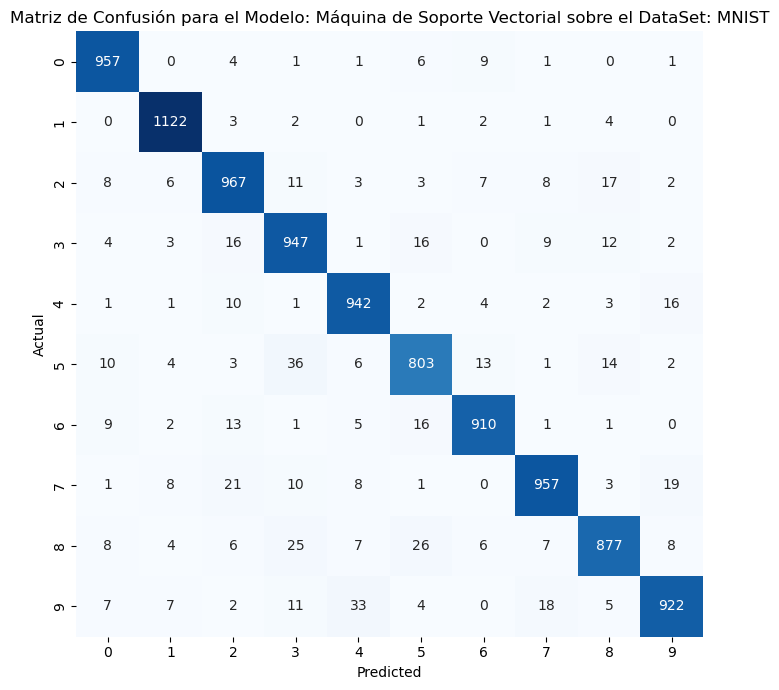

In [159]:
y_pred_mnist_svm = evaluate_model(svm_mnist, x_test_mnist_flat, y_test_mnist, "Máquina de Soporte Vectorial", "MNIST")

Reporte de Clasificación para el Modelo: Máquina de Soporte Vectorial sobre el DataSet: Fashion MNIST:
              precision    recall  f1-score   support

           0       0.75      0.81      0.78      1000
           1       0.97      0.96      0.97      1000
           2       0.74      0.77      0.75      1000
           3       0.85      0.84      0.85      1000
           4       0.76      0.77      0.77      1000
           5       0.93      0.94      0.93      1000
           6       0.63      0.56      0.59      1000
           7       0.92      0.93      0.93      1000
           8       0.95      0.93      0.94      1000
           9       0.95      0.94      0.95      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



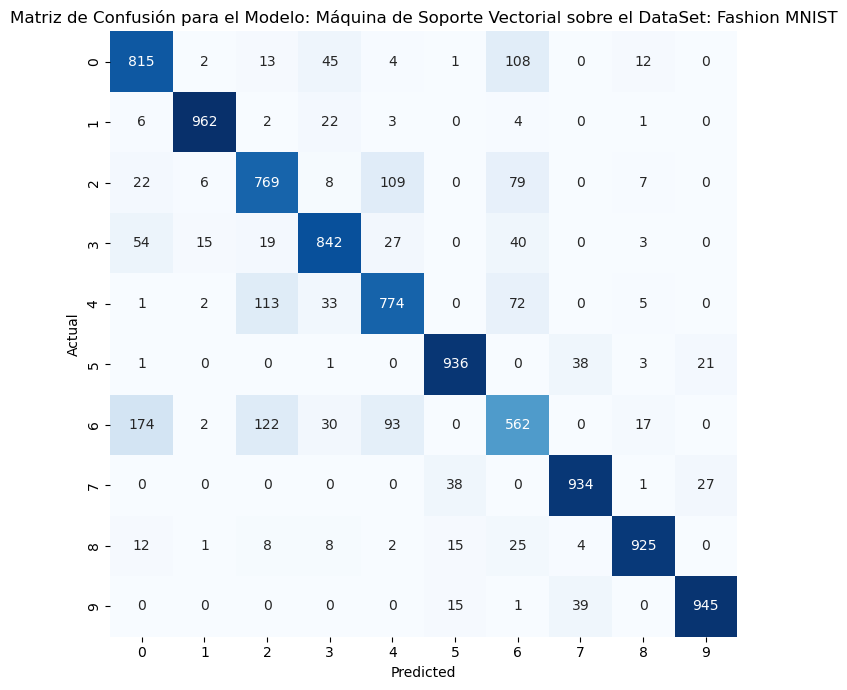

In [158]:
y_pred_mnistfashion_svm = evaluate_model(svm_fashion, x_test_fashion_flat, y_test_fashion, "Máquina de Soporte Vectorial", "Fashion MNIST")

In [ ]:
predicciones['svm_mnist'] = y_pred_mnist_svm
predicciones['svm_fashion'] = y_pred_mnistfashion_svm

##### Accuracy de los dos modelos para cada DataSet

In [44]:
accuracy_svm_mnist = accuracy_score(y_test_mnist, y_pred_mnist_svm)
accuracy_svm_mnistfahion = accuracy_score(y_test_fashion, y_pred_mnistfashion_svm)
print("Accuracy de SVM en MNIST: ", accuracy_svm_mnist*100)
print("Accuracy de SVM en Fashion MNIST: ", accuracy_svm_mnistfahion*100)

Accuracy de SVM en MNIST:  94.04
Accuracy de SVM en Fashion MNIST:  84.64


### Implementación del Modelo RandomForest para MNIST y Fashion MNIST

Opté por utilizar la implementación `RandomForestClassifier` de `scikit-learn`. Iniciaré con un número moderado de árboles en el bosque para obtener un buen balance entre tiempo de entrenamiento y rendimiento del modelo.

##### Creación y entrenamiento del modelo RandomForest para MNIST

In [80]:
rf_mnist = RandomForestClassifier(n_estimators=100, random_state=42)
rf_mnist.fit(x_train_mnist_flat, y_train_mnist)

RandomForestClassifier(random_state=42)

In [81]:
dump(rf_mnist, 'rf_mnist.joblib')

['rf_mnist.joblib']

##### Creación y entrenamiento del modelo RandomForest para Fashion MNIST

In [82]:
rf_fashion = RandomForestClassifier(n_estimators=100, random_state=42)
rf_fashion.fit(x_train_fashion_flat, y_train_fashion)

RandomForestClassifier(random_state=42)

In [83]:
dump(rf_fashion, 'rf_fashion.joblib')

['rf_fashion.joblib']

### Uso de la función `evaluate_model` para cada modelo y dataset

Reporte de Clasificación para el Modelo: RandomForest sobre el DataSet: MNIST:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.97      0.97      1032
           3       0.96      0.96      0.96      1010
           4       0.97      0.97      0.97       982
           5       0.98      0.96      0.97       892
           6       0.98      0.98      0.98       958
           7       0.97      0.96      0.97      1028
           8       0.96      0.95      0.96       974
           9       0.96      0.95      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



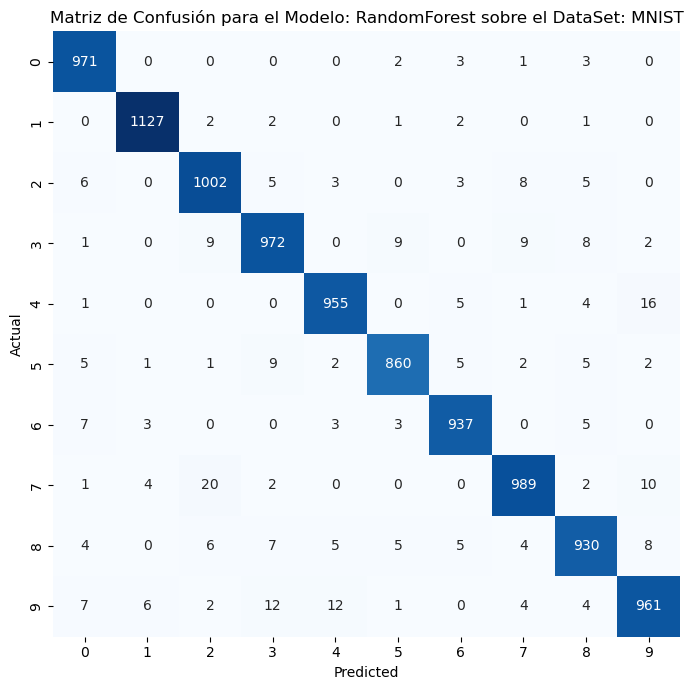

In [157]:
y_pred_mnist_rf = evaluate_model(rf_mnist, x_test_mnist_flat, y_test_mnist, "RandomForest", "MNIST")

Reporte de Clasificación para el Modelo: RandomForest sobre el DataSet: Fashion MNIST:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84      1000
           1       0.99      0.96      0.98      1000
           2       0.77      0.81      0.79      1000
           3       0.88      0.90      0.89      1000
           4       0.77      0.82      0.79      1000
           5       0.98      0.96      0.97      1000
           6       0.71      0.58      0.64      1000
           7       0.93      0.95      0.94      1000
           8       0.96      0.97      0.97      1000
           9       0.95      0.94      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.87     10000
weighted avg       0.88      0.88      0.87     10000



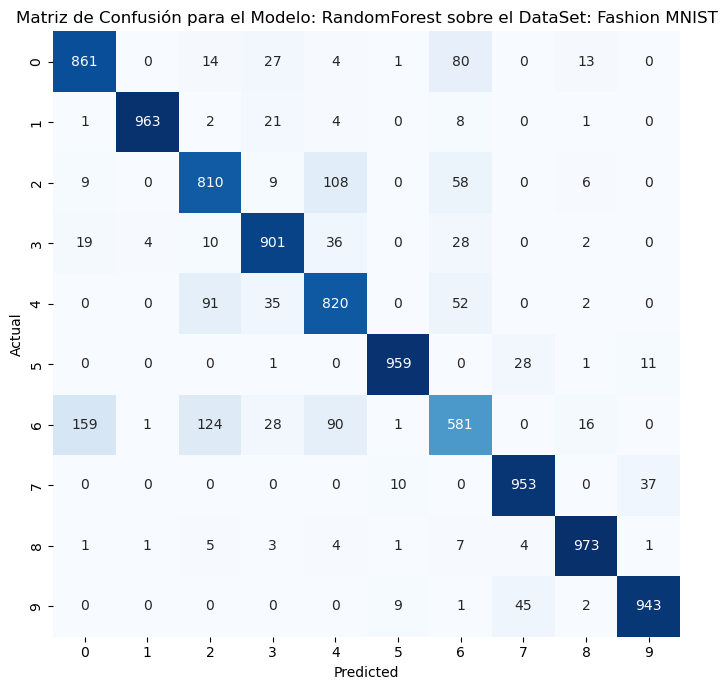

In [156]:
y_pred_mnistfashion_rf = evaluate_model(rf_fashion, x_test_fashion_flat, y_test_fashion, "RandomForest", "Fashion MNIST")

In [ ]:
predicciones['rf_mnist'] = y_pred_mnist_rf
predicciones['rf_fashion'] = y_pred_mnistfashion_rf

##### Accuracy de los dos modelos para cada DataSet

In [86]:
accuracy_rf_mnist = accuracy_score(y_test_mnist, y_pred_mnist_rf)
accuracy_rf_mnistfahion = accuracy_score(y_test_fashion, y_pred_mnistfashion_rf)
print("Accuracy de RandomForest en MNIST: ", accuracy_rf_mnist*100)
print("Accuracy de RandomForest en Fashion MNIST: ", accuracy_rf_mnistfahion*100)

Accuracy de RandomForest en MNIST:  97.04
Accuracy de RandomForest en Fashion MNIST:  87.64


### Implementación del Modelo MLPClassifier para MNIST y Fashion MNIST

A continuación, procederé con la implementación de un modelo de Red Neuronal utilizando `MLPClassifier` de la biblioteca `scikit-learn`. Este tipo de modelo puede capturar relaciones no lineales complejas en los datos, lo que lo hace adecuado para los datasets MNIST y Fashion MNIST, que contienen imágenes de alta dimensionalidad.

Elegiré una configuración básica para el MLPClassifier para comenzar, utilizando una sola capa oculta con una cantidad moderada de neuronas. Esto debería proporcionarme un buen equilibrio entre capacidad de modelado y riesgo de sobreajuste.

##### Creación y entrenamiento del modelo MLP para MNIST

In [47]:
mlp_mnist = MLPClassifier(hidden_layer_sizes=(128,), max_iter=300, random_state=42, verbose=True)
mlp_mnist.fit(x_train_mnist_flat, y_train_mnist)

MLPClassifier(hidden_layer_sizes=(128,), max_iter=300, random_state=42)

In [56]:
dump(mlp_mnist, 'mlp_mnist.joblib')

['mlp_mnist.joblib']

##### Creación y entrenamiento del modelo MLP para Fashion MNIST

In [48]:
mlp_fashion = MLPClassifier(hidden_layer_sizes=(128,), max_iter=300, random_state=42, verbose=True)
mlp_fashion.fit(x_train_fashion_flat, y_train_fashion)


MLPClassifier(hidden_layer_sizes=(128,), max_iter=300, random_state=42)

In [55]:
dump(mlp_fashion, 'mlp_fashion.joblib')

['mlp_fashion.joblib']

##### Uso de la función `evaluate_model` para cada modelo y dataset


Reporte de Clasificación para el Modelo: MLPClassifier sobre el DataSet: MNIST:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.97      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.99      0.97      0.98       892
           6       0.98      0.98      0.98       958
           7       0.98      0.97      0.98      1028
           8       0.97      0.97      0.97       974
           9       0.97      0.98      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



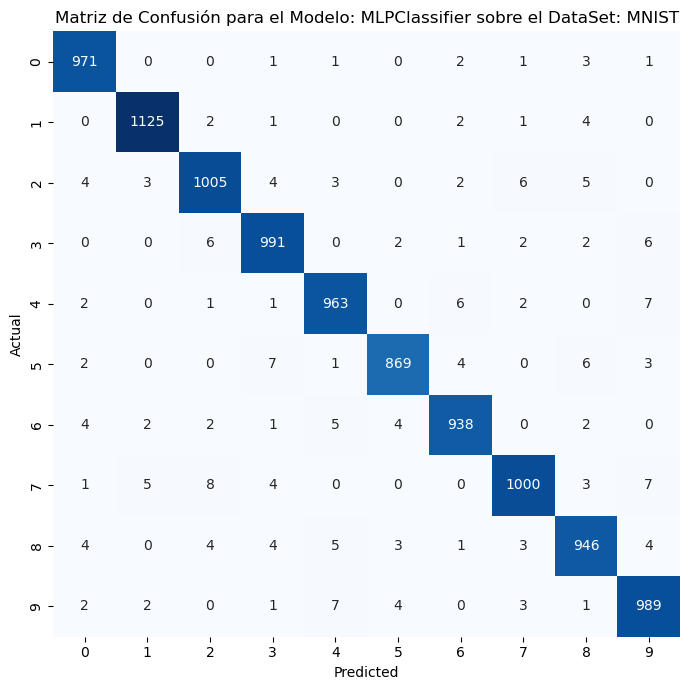

In [155]:
y_pred_mnist_mlp = evaluate_model(mlp_mnist, x_test_mnist_flat, y_test_mnist, "MLPClassifier", "MNIST")

Reporte de Clasificación para el Modelo: MLPClassifier sobre el DataSet: Fashion MNIST:
              precision    recall  f1-score   support

           0       0.82      0.85      0.84      1000
           1       0.98      0.98      0.98      1000
           2       0.82      0.78      0.80      1000
           3       0.90      0.87      0.88      1000
           4       0.77      0.84      0.81      1000
           5       0.97      0.95      0.96      1000
           6       0.73      0.68      0.71      1000
           7       0.93      0.97      0.95      1000
           8       0.95      0.96      0.96      1000
           9       0.96      0.96      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



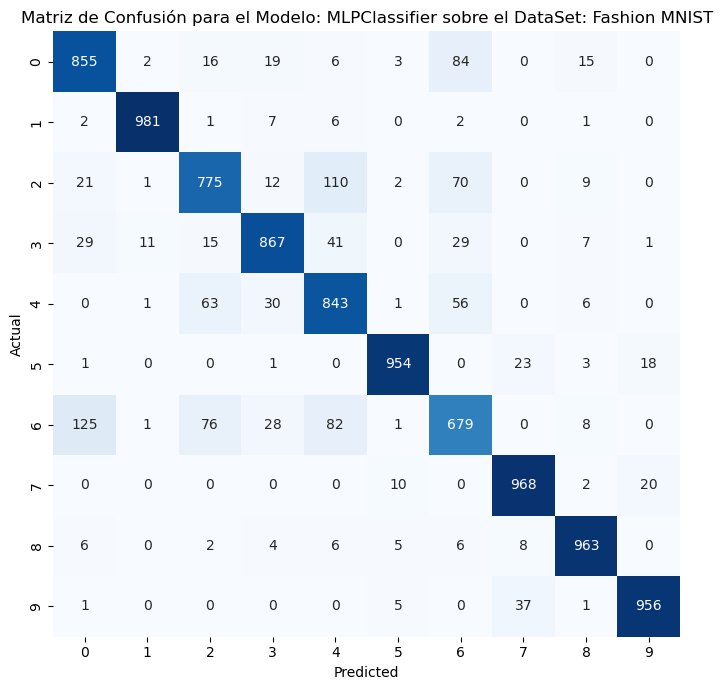

In [154]:
y_pred_mnistfashion_mlp = evaluate_model(mlp_fashion, x_test_fashion_flat, y_test_fashion, "MLPClassifier", "Fashion MNIST")

In [ ]:
predicciones['mlp_mnist'] = y_pred_mnist_mlp
predicciones['mlp_fashion'] = y_pred_mnistfashion_mlp

##### Accuracy de los dos modelos para cada DataSet

In [52]:
accuracy_mlp_mnist = accuracy_score(y_test_mnist, y_pred_mnist_mlp)
accuracy_mlp_mnistfahion = accuracy_score(y_test_fashion, y_pred_mnistfashion_mlp)
print("Accuracy de MLPClassifier en MNIST: ", accuracy_mlp_mnist*100)
print("Accuracy de MLPClassifier en Fashion MNIST: ", accuracy_mlp_mnistfahion*100)

Accuracy de MLPClassifier en MNIST:  97.97
Accuracy de MLPClassifier en Fashion MNIST:  88.41


### Implementación de una Red Neuronal Profunda (DNN) para MNIST y Fashion MNIST
Ahora abordaré el desafío de clasificación de imágenes utilizando una Red Neuronal Profunda (DNN) para los datasets MNIST y Fashion MNIST. Las redes neuronales profundas son particularmente eficaces para este tipo de tareas debido a su capacidad para aprender características jerárquicas de los datos, lo que es ideal para el reconocimiento de patrones en imágenes.

Usaré TensorFlow y Keras para construir y entrenar una DNN con múltiples capas ocultas. Esto permitirá a la red capturar complejidades en los datos a través de múltiples representaciones abstractas.

In [125]:
def build_model():
    model = Sequential([
        Dense(512, activation='relu', input_shape=(784,)),  # 784 es el número de píxeles en cada imagen (28x28)
        Dropout(0.2),  # Dropout para reducir el overfitting
        Dense(512, activation='relu'),
        Dropout(0.2),
        Dense(10, activation='softmax')  # 10 clases de salida para MNIST y Fashion MNIST, como son iguales las cantidades la dejo así
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

##### Creación y entrenamiento del modelo DNN para MNIST

In [97]:
dnn_mnist = build_model()
history_dnn_mnist = dnn_mnist.fit(x_train_mnist_flat, y_train_mnist, epochs=10, validation_split=0.1, verbose = 1)

Epoch 1/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.8817 - loss: 0.3748 - val_accuracy: 0.9755 - val_loss: 0.0844
Epoch 2/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.9659 - loss: 0.1103 - val_accuracy: 0.9762 - val_loss: 0.0746
Epoch 3/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - accuracy: 0.9751 - loss: 0.0789 - val_accuracy: 0.9795 - val_loss: 0.0757
Epoch 4/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.9803 - loss: 0.0653 - val_accuracy: 0.9812 - val_loss: 0.0729
Epoch 5/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.9815 - loss: 0.0598 - val_accuracy: 0.9815 - val_loss: 0.0618
Epoch 6/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.9848 - loss: 0.0495 - val_accuracy: 0.9788 - val_loss: 0.0807
Epoch 7/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.9864 - loss: 0.0426 - val_accuracy: 0.9808 - val_loss: 0.0719
Epoch 8/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.9862 - loss

In [98]:
dnn_mnist.save('dnn_mnist.keras')

##### Graficar la precisión de entrenamiento y validación

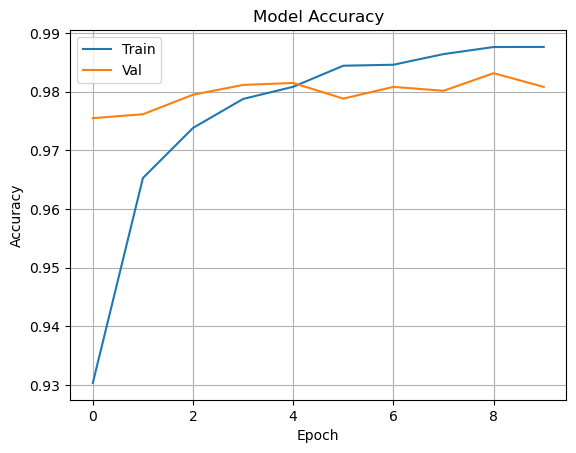

In [101]:
plt.plot(history_dnn_mnist.history['accuracy'])
plt.plot(history_dnn_mnist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.grid()
plt.show()

##### Graficar la pérdida de entrenamiento y validación

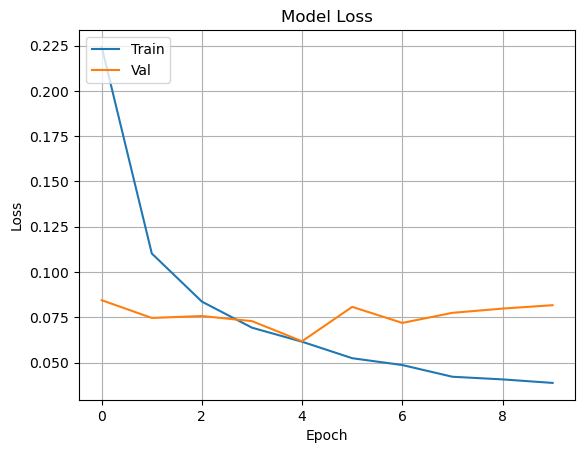

In [102]:
plt.plot(history_dnn_mnist.history['loss'])
plt.plot(history_dnn_mnist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.grid()
plt.show()

##### Uso de la función `evaluate_model` para cada modelo y dataset

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Reporte de Clasificación para el Modelo: DNN sobre el DataSet: MNIST:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.99      0.98      1032
           3       0.97      0.98      0.97      1010
           4       0.98      0.98      0.98       982
           5       0.99      0.97      0.98       892
           6       0.98      0.99      0.98       958
           7       0.99      0.98      0.98      1028
           8       0.96      0.98      0.97       974
           9       0.99      0.97      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



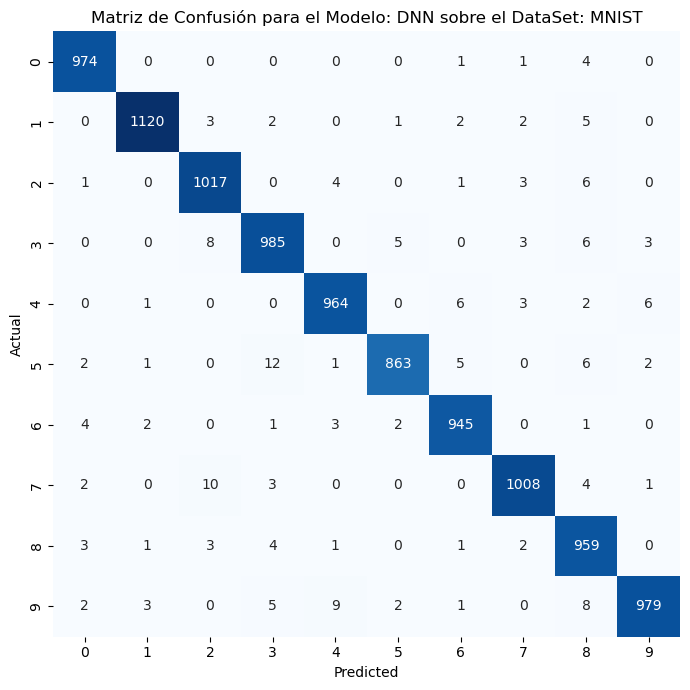

In [153]:
y_pred_mnist_dnn = evaluate_model(dnn_mnist, x_test_mnist_flat, y_test_mnist, "DNN", "MNIST")

##### Creación y entrenamiento del modelo DNN para Fashion MNIST

In [103]:
dnn_fashion = build_model()
history_dnn_fashion = dnn_fashion.fit(x_train_fashion_flat, y_train_fashion, epochs=10, validation_split=0.1, verbose = 1)

Epoch 1/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.7708 - loss: 0.6408 - val_accuracy: 0.8525 - val_loss: 0.4009
Epoch 2/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.8518 - loss: 0.4004 - val_accuracy: 0.8712 - val_loss: 0.3619
Epoch 3/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.8621 - loss: 0.3722 - val_accuracy: 0.8750 - val_loss: 0.3487
Epoch 4/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.8703 - loss: 0.3470 - val_accuracy: 0.8775 - val_loss: 0.3329
Epoch 5/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.8793 - loss: 0.3263 - val_accuracy: 0.8733 - val_loss: 0.3430
Epoch 6/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.8777 - loss: 0.3243 - val_accuracy: 0.8787 - val_loss: 0.3250
Epoch 7/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - accuracy: 0.8867 - loss: 0.3045 - val_accuracy: 0.8837 - val_loss: 0.3236
Epoch 8/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 35s 9ms/step - accuracy: 0.8896 - loss

In [104]:
dnn_fashion.save('dnn_fashion.keras')

##### Graficar la precisión de entrenamiento y validación

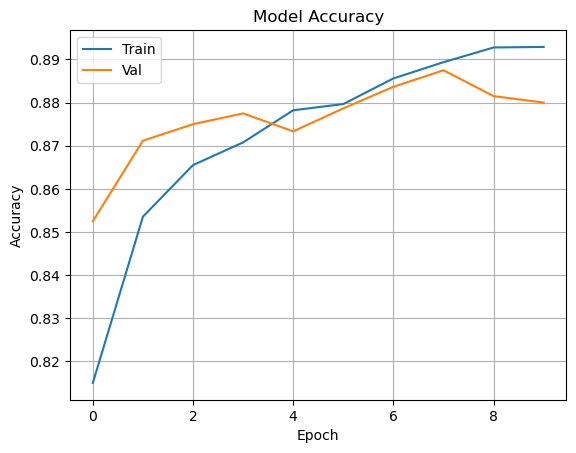

In [121]:
plt.plot(history_dnn_fashion.history['accuracy'])
plt.plot(history_dnn_fashion.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.grid()
plt.show()

##### Graficar la pérdida de entrenamiento y validación

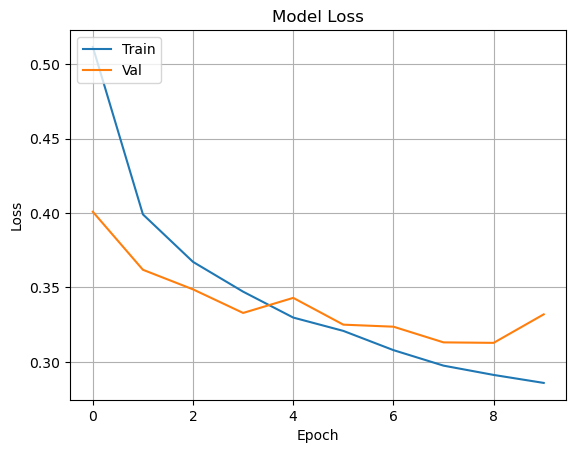

In [120]:
plt.plot(history_dnn_fashion.history['loss'])
plt.plot(history_dnn_fashion.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.grid()
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Reporte de Clasificación para el Modelo: DNN sobre el DataSet: Fashion MNIST:
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      1000
           1       0.99      0.97      0.98      1000
           2       0.87      0.61      0.72      1000
           3       0.87      0.90      0.88      1000
           4       0.72      0.86      0.78      1000
           5       0.99      0.95      0.97      1000
           6       0.66      0.71      0.68      1000
           7       0.91      0.98      0.94      1000
           8       0.98      0.96      0.97      1000
           9       0.98      0.93      0.95      1000

    accuracy                           0.87     10000
   macro avg       0.88      0.87      0.87     10000
weighted avg       0.88      0.87      0.87     10000



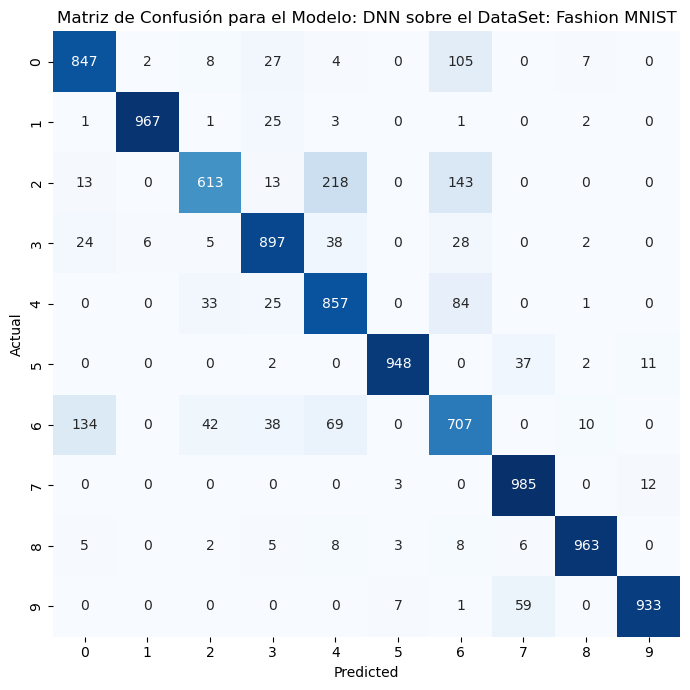

In [48]:
y_pred_mnistfashion_dnn = evaluate_model(dnn_fashion, x_test_fashion_flat, y_test_fashion, "DNN", "Fashion MNIST")

In [ ]:
predicciones['dnn_mnist'] = y_pred_mnist_dnn
predicciones['dnn_fashion'] = y_pred_mnistfashion_dnn

In [136]:
accuracy_dnn_mnist = accuracy_score(y_test_mnist, y_pred_mnist_dnn)
accuracy_dnn_mnistfahion = accuracy_score(y_test_fashion, y_pred_mnistfashion_dnn)
print("Accuracy de DNN en MNIST: ", accuracy_dnn_mnist*100)
print("Accuracy de DNN en Fashion MNIST: ", accuracy_dnn_mnistfahion*100)

Accuracy de DNN en MNIST:  98.14
Accuracy de DNN en Fashion MNIST:  87.17


### Implementación de una Red Neuronal Convolucional (CNN) para MNIST y Fashion MNIST
Para abordar la clasificación de imágenes con una Red Neuronal Convolucional (CNN) en los datasets MNIST y Fashion MNIST, diseñaré y entrenaré un modelo CNN utilizando TensorFlow y Keras. Las CNNs son especialmente adecuadas para el procesamiento de imágenes debido a su capacidad para capturar patrones espaciales y jerárquicos a través de sus filtros convolucionales.

Utilizaré Keras para construir una CNN básica que incluya capas convolucionales, capas de activación ReLU, y capas de pooling para reducir la dimensionalidad mientras se preservan las características importantes.

In [124]:
def build_cnn_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

##### Reajuste de los datos para incluir la dimensión del canal para la CNN

In [18]:
x_train_mnist_cnn = x_train_mnist.reshape((-1, 28, 28, 1))
x_test_mnist_cnn = x_test_mnist.reshape((-1, 28, 28, 1))
x_train_fashion_cnn = x_train_fashion.reshape((-1, 28, 28, 1))
x_test_fashion_cnn = x_test_fashion.reshape((-1, 28, 28, 1))

##### Creación y entrenamiento del modelo CNN para MNIST

In [129]:
cnn_mnist = build_cnn_model()
history_mnist_cnn = cnn_mnist.fit(x_train_mnist_cnn, y_train_mnist, epochs=10, validation_split=0.1, verbose = 1)

Epoch 1/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - accuracy: 0.8824 - loss: 0.3686 - val_accuracy: 0.9827 - val_loss: 0.0540
Epoch 2/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 43s 14ms/step - accuracy: 0.9851 - loss: 0.0487 - val_accuracy: 0.9882 - val_loss: 0.0396
Epoch 3/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - accuracy: 0.9904 - loss: 0.0304 - val_accuracy: 0.9890 - val_loss: 0.0344
Epoch 4/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - accuracy: 0.9918 - loss: 0.0250 - val_accuracy: 0.9905 - val_loss: 0.0355
Epoch 5/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - accuracy: 0.9940 - loss: 0.0192 - val_accuracy: 0.9863 - val_loss: 0.0441
Epoch 6/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - accuracy: 0.9954 - loss: 0.0152 - val_accuracy: 0.9915 - val_loss: 0.0370
Epoch 7/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - accuracy: 0.9965 - loss: 0.0117 - val_accuracy: 0.9910 - val_loss: 0.0370
Epoch 8/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.9967 -

In [130]:
cnn_mnist.save('cnn_mnist.keras')

##### Graficar la precisión de entrenamiento y validación

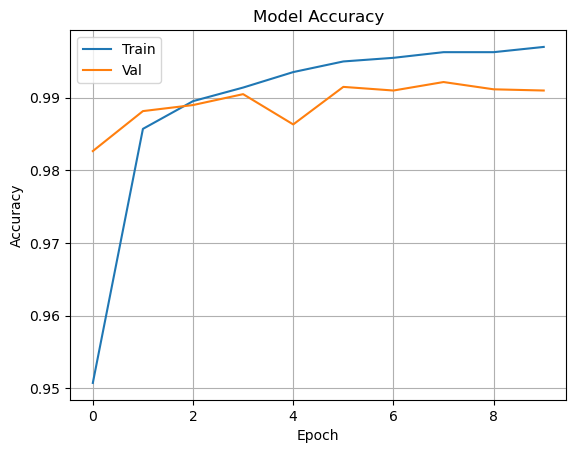

In [131]:
plt.plot(history_mnist_cnn.history['accuracy'])
plt.plot(history_mnist_cnn.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.grid()
plt.show()

##### Graficar la pérdida de entrenamiento y validación

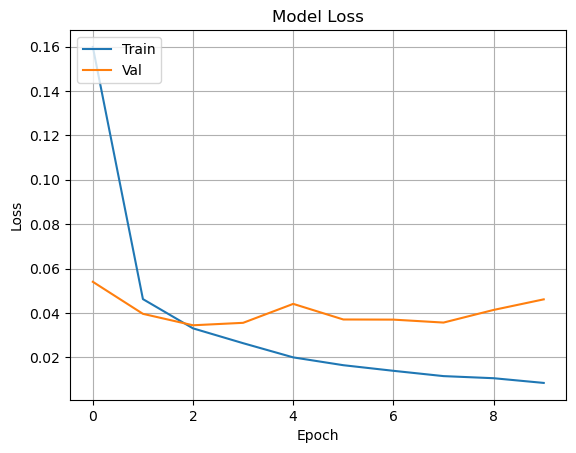

In [132]:
plt.plot(history_mnist_cnn.history['loss'])
plt.plot(history_mnist_cnn.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.grid()
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Reporte de Clasificación para el Modelo: CNN sobre el DataSet: MNIST:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      1.00      1135
           2       0.99      0.99      0.99      1032
           3       0.99      1.00      0.99      1010
           4       1.00      0.98      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       1.00      0.99      0.99       974
           9       0.97      0.99      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



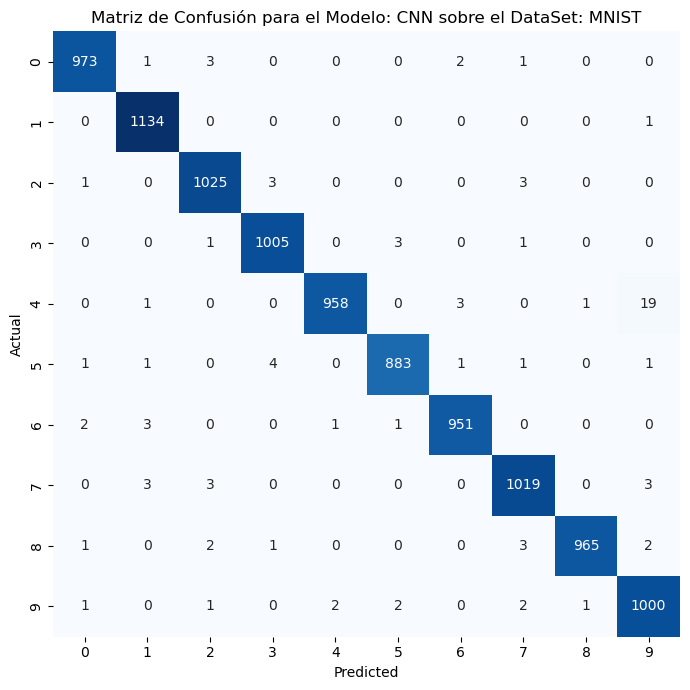

In [151]:
y_pred_mnist_cnn = evaluate_model(cnn_mnist, x_test_mnist_cnn, y_test_mnist, "CNN", "MNIST")

##### Creación y entrenamiento del modelo CNN para Fashion MNIST

In [135]:
cnn_fashion = build_cnn_model()
history_fashion_cnn = cnn_fashion.fit(x_train_fashion_cnn, y_train_fashion, epochs=10, validation_split=0.1)

C:\Users\MATIA\anaconda3\envs\tfi_especializacion\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.7432 - loss: 0.6995 - val_accuracy: 0.8742 - val_loss: 0.3606
Epoch 2/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - accuracy: 0.8780 - loss: 0.3328 - val_accuracy: 0.8783 - val_loss: 0.3212
Epoch 3/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - accuracy: 0.8996 - loss: 0.2742 - val_accuracy: 0.8955 - val_loss: 0.2927
Epoch 4/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.9103 - loss: 0.2427 - val_accuracy: 0.9047 - val_loss: 0.2617
Epoch 5/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - accuracy: 0.9179 - loss: 0.2205 - val_accuracy: 0.9057 - val_loss: 0.2612
Epoch 6/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - accuracy: 0.9258 - loss: 0.2004 - val_accuracy: 0.9090 - val_loss: 0.2464
Epoch 7/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.9321 - loss: 0.1833 - val_accuracy: 0.9102 - val_loss: 0.2448
Epoch 8/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - accuracy: 0.9393 -

In [137]:
cnn_fashion.save('cnn_fashion.keras')

##### Graficar la precisión de entrenamiento y validación

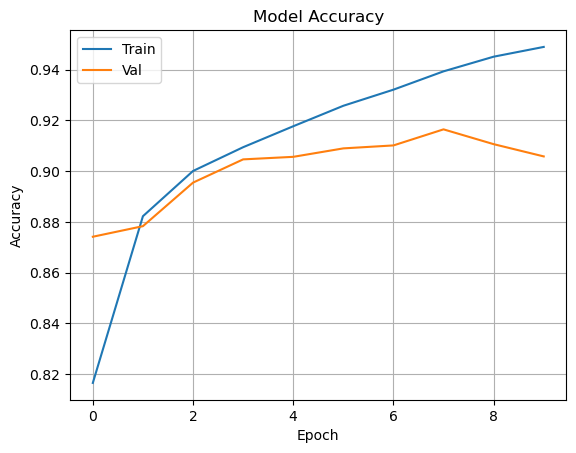

In [138]:
plt.plot(history_fashion_cnn.history['accuracy'])
plt.plot(history_fashion_cnn.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.grid()
plt.show()

##### Graficar la pérdida de entrenamiento y validación

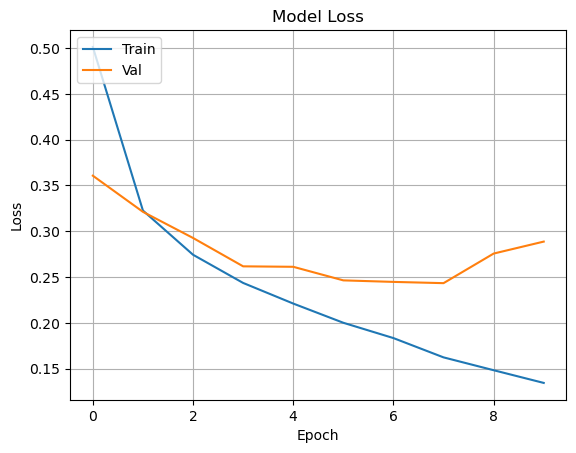

In [139]:
plt.plot(history_fashion_cnn.history['loss'])
plt.plot(history_fashion_cnn.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.grid()
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Reporte de Clasificación para el Modelo: CNN sobre el DataSet: Fashion MNIST:
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1000
           1       0.99      0.98      0.98      1000
           2       0.83      0.89      0.86      1000
           3       0.94      0.88      0.91      1000
           4       0.83      0.89      0.86      1000
           5       0.99      0.97      0.98      1000
           6       0.76      0.68      0.72      1000
           7       0.92      0.99      0.95      1000
           8       0.99      0.97      0.98      1000
           9       0.99      0.94      0.96      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



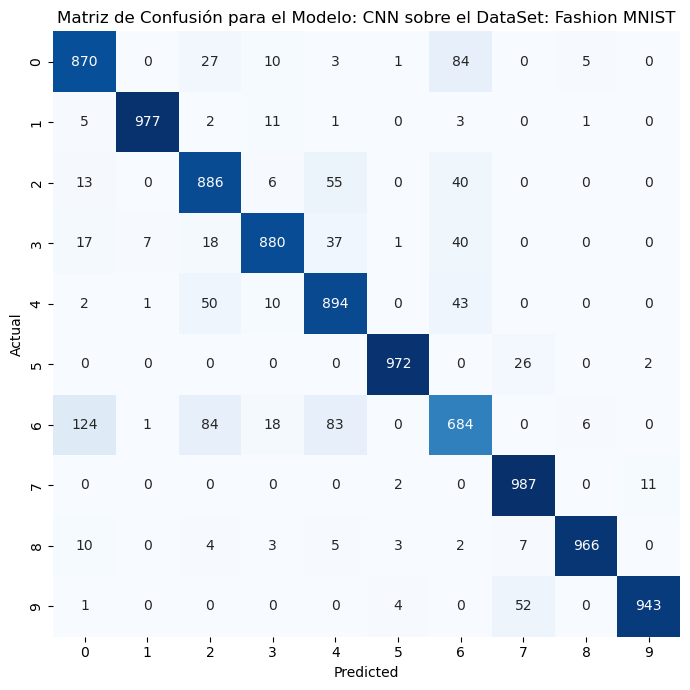

In [149]:
y_pred_mnistfashion_cnn = evaluate_model(cnn_fashion, x_test_fashion_cnn, y_test_fashion, "CNN", "Fashion MNIST")

In [ ]:
predicciones['cnn_mnist'] = y_pred_mnist_cnn
predicciones['cnn_fashion'] = y_pred_mnistfashion_cnn

In [256]:
with open('predicciones.pkl', 'wb') as f:
    pickle.dump(predicciones, f)

In [141]:
accuracy_cnn_mnist = accuracy_score(y_test_mnist, y_pred_mnist_cnn)
accuracy_cnn_mnistfahion = accuracy_score(y_test_fashion, y_pred_mnistfashion_cnn)
print("Accuracy de CNN en MNIST: ", accuracy_cnn_mnist*100)
print("Accuracy de CNN en Fashion MNIST: ", accuracy_cnn_mnistfahion*100)

Accuracy de CNN en MNIST:  99.13
Accuracy de CNN en Fashion MNIST:  90.59


In [165]:
resultados.sort_values(by=['Dataset', 'Accuracy'], ascending=[False, False])

,Dataset,Modelo,Descripcion,Accuracy
1,MNIST,CNN,"<Sequential name=sequential_5, built=True>",0.9913
3,MNIST,DNN,"<Sequential name=sequential_1, built=True>",0.9814
5,MNIST,MLPClassifier,"MLPClassifier(hidden_layer_sizes=(128,), max_i...",0.9797
7,MNIST,RandomForest,"(DecisionTreeClassifier(max_features='sqrt', r...",0.9704
9,MNIST,Máquina de Soporte Vectorial,"SVC(kernel='linear', random_state=42)",0.9404
13,MNIST,Regresión Logística,"LogisticRegression(max_iter=1000, random_state...",0.9264
11,MNIST,Árbol de Decisión,DecisionTreeClassifier(random_state=42),0.8754
0,Fashion MNIST,CNN,"<Sequential name=sequential_6, built=True>",0.9059
4,Fashion MNIST,MLPClassifier,"MLPClassifier(hidden_layer_sizes=(128,), max_i...",0.8841
6,Fashion MNIST,RandomForest,"(DecisionTreeClassifier(max_features='sqrt', r...",0.8764


## Carga de modelos y predicciones almacenadas

Esto lo hago debido a que la ejecución de cada modelo tarda un tiempo considerable, de esta manera en caso de perder la ejecución del entorno, se podría volver a levantar cada uno de ellos y no ejecutarlo nuevamente, como así también las predicciones de cada modelo.

### Identificar los Archivos de Modelo y cargarlos en Diccionario
Primero, listar todos los archivos de modelo en un directorio específico. Esto se puede hacer usando la biblioteca `os`, además de cargarlos en un diccionario:

In [11]:
# Directorio donde están almacenados los modelos
model_dir = '../trabajo_final_especializacion'

# Diccionario para almacenar los modelos
models = {}

# Cargar los modelos y almacenarlos en el diccionario
for file in os.listdir(model_dir):
    if file.endswith('.keras') or file.endswith('.joblib'):
        file_path = os.path.join(model_dir, file)
        model_name = file.split('.')[0]  # Elimina la extensión del archivo para usar como clave del diccionario
        if file.endswith('.keras'):
            models[model_name] = load_model(file_path)
        elif file.endswith('.joblib'):
            models[model_name] = load(file_path)
        else:
            print(f"Modelo no soportado para el archivo: {file}")

Skipping variable loading for optimizer 'rmsprop', because it has 8 variables whereas the saved optimizer has 14 variables. 


In [12]:
models

{'cnn_fashion': <Sequential name=sequential_6, built=True>,
 'cnn_mnist': <Sequential name=sequential_5, built=True>,
 'dnn_fashion': <Sequential name=sequential_2, built=True>,
 'dnn_mnist': <Sequential name=sequential, built=True>,
 'logreg_fashion': LogisticRegression(max_iter=1000, random_state=42),
 'logreg_mnist': LogisticRegression(max_iter=1000, random_state=42),
 'mlp_fashion': MLPClassifier(hidden_layer_sizes=(128,), max_iter=300, random_state=42),
 'mlp_mnist': MLPClassifier(hidden_layer_sizes=(128,), max_iter=300, random_state=42),
 'rf_fashion': RandomForestClassifier(random_state=42),
 'rf_mnist': RandomForestClassifier(random_state=42),
 'svm_fashion': SVC(kernel='linear', probability=True, random_state=42),
 'svm_mnist': SVC(kernel='linear', probability=True, random_state=42),
 'tree_fashion': DecisionTreeClassifier(random_state=42),
 'tree_mnist': DecisionTreeClassifier(random_state=42)}

Los ordenaré para que queden juntos lo de MNIST y Fashion

In [13]:
sorted_keys = sorted(models.keys(), key=lambda x: (x.split('_')[1] == 'fashion', x.split('_')[0]))

In [14]:
models = {key: models[key] for key in sorted_keys}

In [15]:
models

{'cnn_mnist': <Sequential name=sequential_5, built=True>,
 'dnn_mnist': <Sequential name=sequential, built=True>,
 'logreg_mnist': LogisticRegression(max_iter=1000, random_state=42),
 'mlp_mnist': MLPClassifier(hidden_layer_sizes=(128,), max_iter=300, random_state=42),
 'rf_mnist': RandomForestClassifier(random_state=42),
 'svm_mnist': SVC(kernel='linear', probability=True, random_state=42),
 'tree_mnist': DecisionTreeClassifier(random_state=42),
 'cnn_fashion': <Sequential name=sequential_6, built=True>,
 'dnn_fashion': <Sequential name=sequential_2, built=True>,
 'logreg_fashion': LogisticRegression(max_iter=1000, random_state=42),
 'mlp_fashion': MLPClassifier(hidden_layer_sizes=(128,), max_iter=300, random_state=42),
 'rf_fashion': RandomForestClassifier(random_state=42),
 'svm_fashion': SVC(kernel='linear', probability=True, random_state=42),
 'tree_fashion': DecisionTreeClassifier(random_state=42)}

In [16]:
with open('predicciones.pkl', 'rb') as f:
    predicciones = pickle.load(f)

# Verificar que el diccionario se haya cargado correctamente
predicciones

{'cnn_mnist': array([7, 2, 1, ..., 4, 5, 6], dtype=int64),
 'dnn_mnist': array([7, 2, 1, ..., 4, 5, 6], dtype=int64),
 'logreg_mnist': array([7, 2, 1, ..., 4, 5, 6], dtype=uint8),
 'mlp_mnist': array([7, 2, 1, ..., 4, 5, 6], dtype=uint8),
 'rf_mnist': array([7, 2, 1, ..., 4, 5, 6], dtype=uint8),
 'svm_mnist': array([7, 2, 1, ..., 4, 5, 6], dtype=uint8),
 'tree_mnist': array([7, 2, 1, ..., 4, 5, 6], dtype=uint8),
 'cnn_fashion': array([9, 2, 1, ..., 8, 1, 5], dtype=int64),
 'dnn_fashion': array([9, 2, 1, ..., 8, 1, 5], dtype=int64),
 'logreg_fashion': array([9, 2, 1, ..., 6, 1, 5], dtype=uint8),
 'mlp_fashion': array([9, 2, 1, ..., 8, 1, 5], dtype=uint8),
 'rf_fashion': array([9, 2, 1, ..., 8, 1, 5], dtype=uint8),
 'svm_fashion': array([9, 2, 1, ..., 6, 1, 5], dtype=uint8),
 'tree_fashion': array([9, 2, 1, ..., 8, 1, 5], dtype=uint8)}

# Predicciones de los Modelos

### Errores en las Predicciones

In [20]:
def display_errors(errors_index, img_errors, pred_errors, obs_errors, labels=None):
    n = 0
    nrows = 1
    ncols = 5
    fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(10, 2))
    for col in range(ncols):
        if n < len(errors_index):
            error = errors_index[n]
            ax[col].imshow((img_errors[error]).reshape((28, 28)), cmap="bone")
            
            if labels is None:
                ax[col].set_title(f"Pred: {pred_errors[error]}\nTrue: {obs_errors[error]}")
            else:
                ax[col].set_title(f"Pred: {labels[pred_errors[error]]} - ({pred_errors[error]})\nTrue: {labels[obs_errors[error]]} - ({obs_errors[error]})")
            n += 1
        else:
            ax[col].axis('off')
    plt.show()

def evaluate_and_display(model, x_test, y_pred, y_test, model_name, labels = None):
    df_nuevo = pd.DataFrame({'pred':y_pred, 'test':y_test})
    mask_df_errores = df_nuevo['pred'] != df_nuevo['test']
    mask_df_correctos = df_nuevo['pred'] == df_nuevo['test']
    indices_errores = df_nuevo[mask_df_errores].tail(6).index
    indices_correctos = df_nuevo[mask_df_correctos].head(15).index
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy del modelo: {model_name}: {accuracy:.2f}")

    print(f"Predichos incorrectamente por el modelo: {model_name}:")
    display_errors(indices_errores, x_test, y_pred, y_test, labels)

    print(f"Predichos correctamente por el modelo: {model_name}:")
    display_errors(indices_correctos, x_test, y_pred, y_test, labels)


    return indices_errores,indices_correctos
    
def get_model_type(key):
    return key.split('_')[0].upper()

# Usar la función evaluate_model existente
def use_evaluate_model(models):
    results = {}
    for name, model in models.items():
        model_type = get_model_type(name)
        print(f"Evaluando {name} ({model_type})...")
        
        if 'mnist' in name:
            x_test = (x_test_mnist_cnn) if 'cnn' in name else (x_test_mnist_flat)
            important_errors,important_corrects=  evaluate_and_display(model,x_test, predicciones[name], y_test_mnist, name)
            
        if 'fashion' in name:
            x_test = (x_test_fashion_cnn) if 'cnn' in name else (x_test_fashion_flat)
            important_errors,important_corrects=  evaluate_and_display(model,x_test, predicciones[name], y_test_fashion, name, fashion_mnist_labels)

        
        results[name] = {
            'Mal predichos': important_errors,
            'Bien predichos': important_corrects
        }

    return results


### Llamar a la función para evaluar los modelos y mostrar correctos e incorrectos

Evaluando cnn_mnist (CNN)...
Accuracy del modelo: cnn_mnist: 0.99
Predichos incorrectamente por el modelo: cnn_mnist:


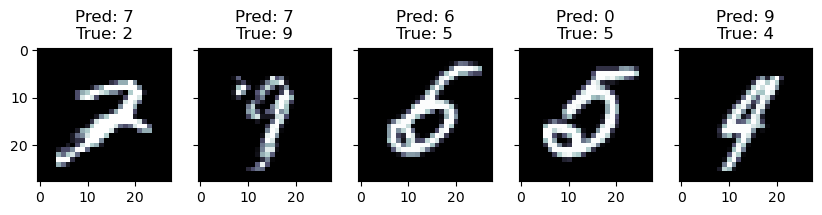

Predichos correctamente por el modelo: cnn_mnist:


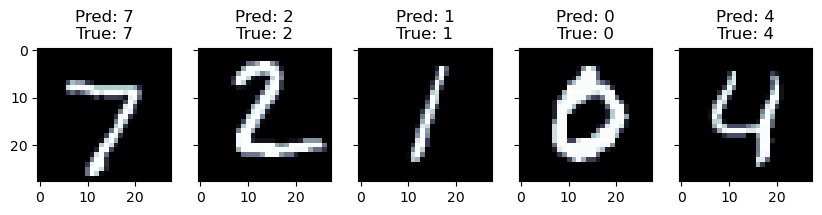

Evaluando dnn_mnist (DNN)...
Accuracy del modelo: dnn_mnist: 0.98
Predichos incorrectamente por el modelo: dnn_mnist:


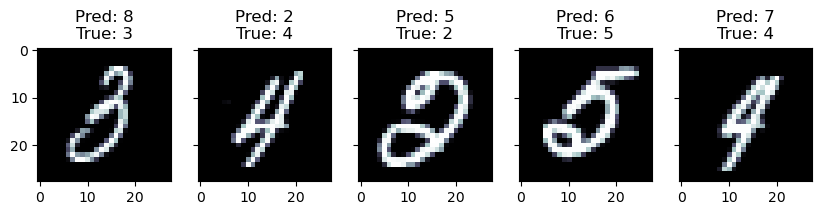

Predichos correctamente por el modelo: dnn_mnist:


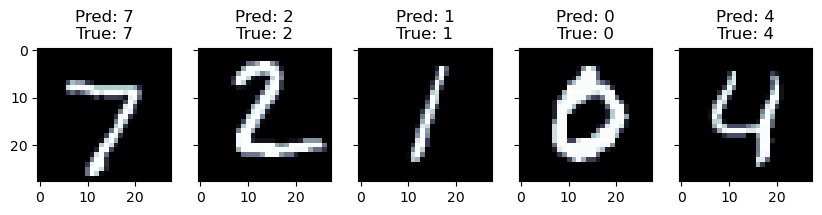

Evaluando logreg_mnist (LOGREG)...
Accuracy del modelo: logreg_mnist: 0.93
Predichos incorrectamente por el modelo: logreg_mnist:


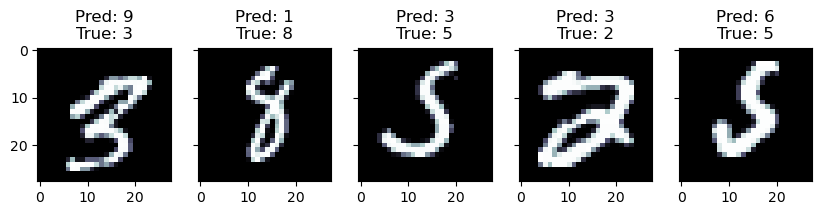

Predichos correctamente por el modelo: logreg_mnist:


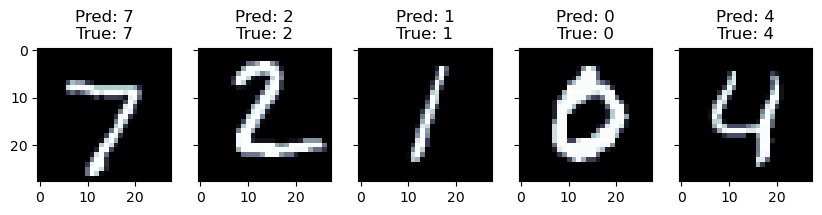

Evaluando mlp_mnist (MLP)...
Accuracy del modelo: mlp_mnist: 0.98
Predichos incorrectamente por el modelo: mlp_mnist:


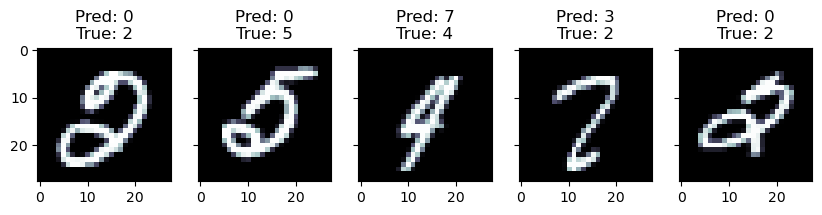

Predichos correctamente por el modelo: mlp_mnist:


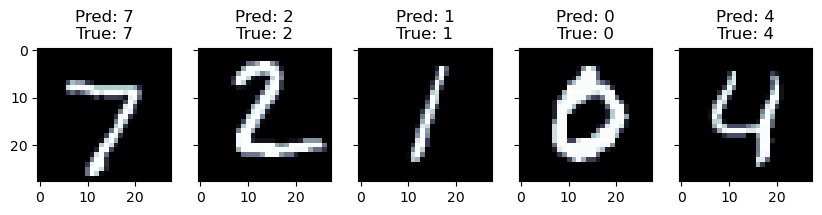

Evaluando rf_mnist (RF)...
Accuracy del modelo: rf_mnist: 0.97
Predichos incorrectamente por el modelo: rf_mnist:


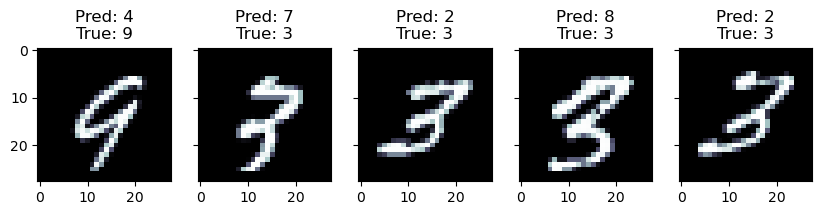

Predichos correctamente por el modelo: rf_mnist:


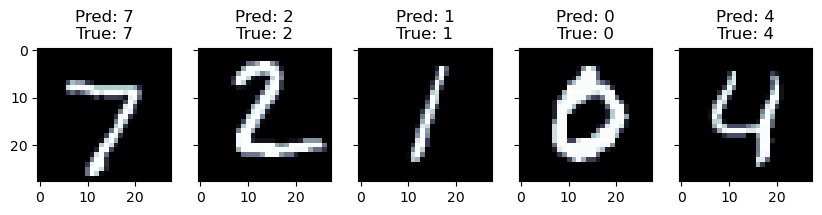

Evaluando svm_mnist (SVM)...
Accuracy del modelo: svm_mnist: 0.94
Predichos incorrectamente por el modelo: svm_mnist:


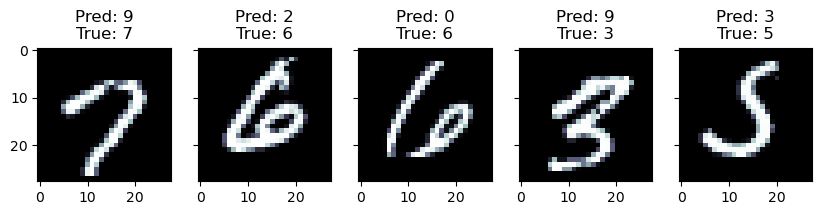

Predichos correctamente por el modelo: svm_mnist:


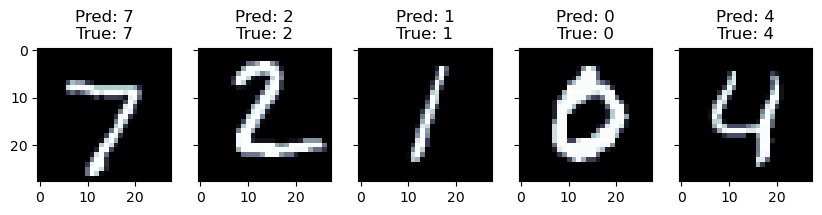

Evaluando tree_mnist (TREE)...
Accuracy del modelo: tree_mnist: 0.88
Predichos incorrectamente por el modelo: tree_mnist:


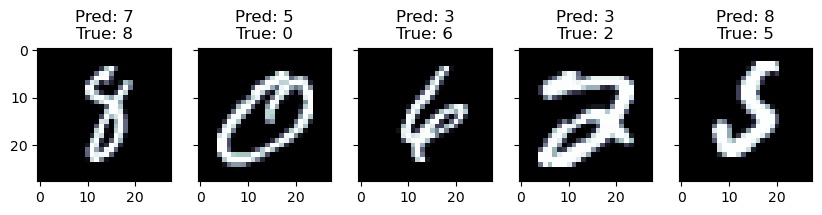

Predichos correctamente por el modelo: tree_mnist:


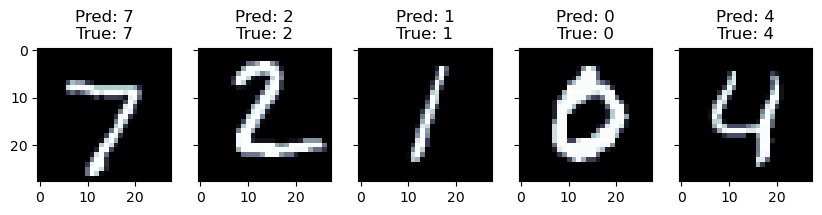

Evaluando cnn_fashion (CNN)...
Accuracy del modelo: cnn_fashion: 0.91
Predichos incorrectamente por el modelo: cnn_fashion:


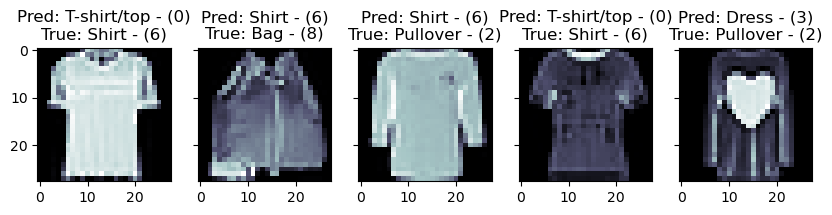

Predichos correctamente por el modelo: cnn_fashion:


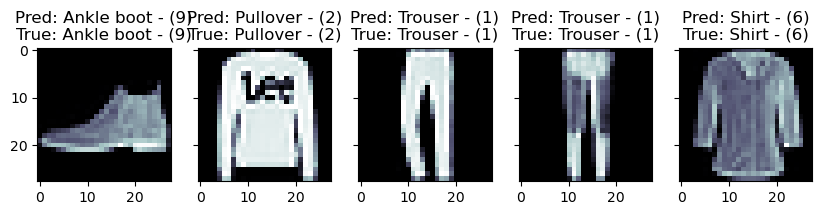

Evaluando dnn_fashion (DNN)...
Accuracy del modelo: dnn_fashion: 0.87
Predichos incorrectamente por el modelo: dnn_fashion:


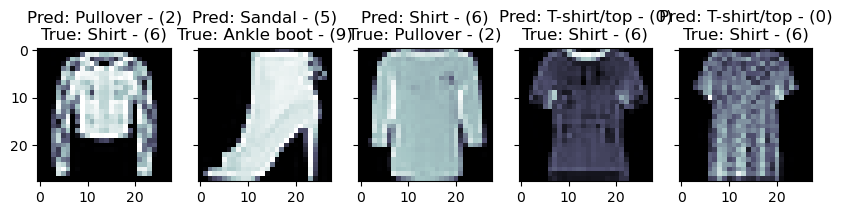

Predichos correctamente por el modelo: dnn_fashion:


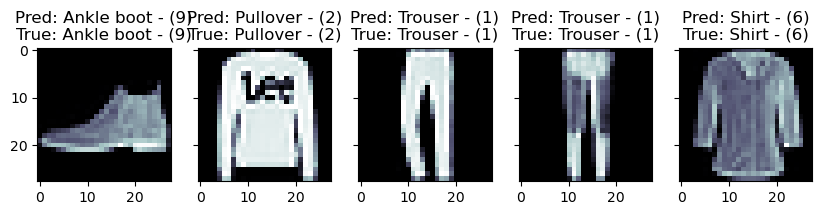

Evaluando logreg_fashion (LOGREG)...
Accuracy del modelo: logreg_fashion: 0.84
Predichos incorrectamente por el modelo: logreg_fashion:


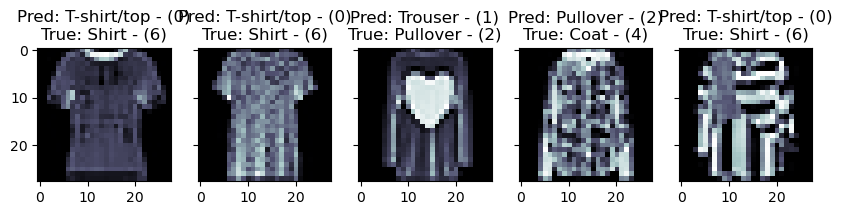

Predichos correctamente por el modelo: logreg_fashion:


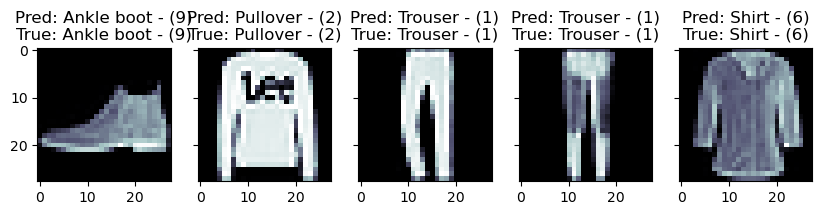

Evaluando mlp_fashion (MLP)...
Accuracy del modelo: mlp_fashion: 0.88
Predichos incorrectamente por el modelo: mlp_fashion:


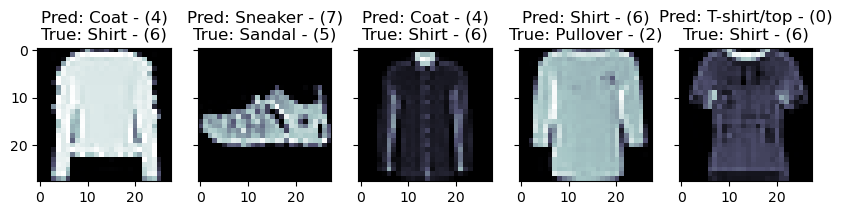

Predichos correctamente por el modelo: mlp_fashion:


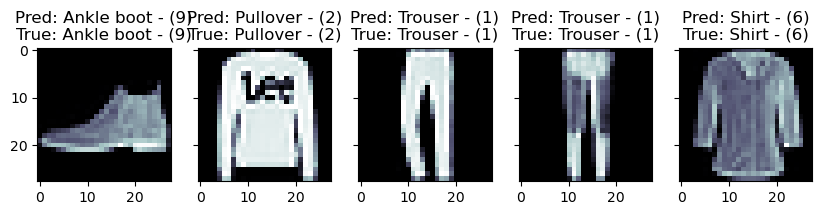

Evaluando rf_fashion (RF)...
Accuracy del modelo: rf_fashion: 0.88
Predichos incorrectamente por el modelo: rf_fashion:


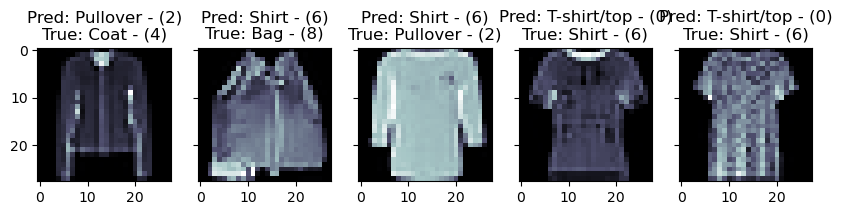

Predichos correctamente por el modelo: rf_fashion:


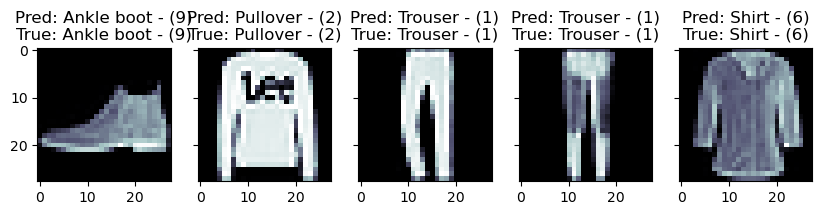

Evaluando svm_fashion (SVM)...
Accuracy del modelo: svm_fashion: 0.85
Predichos incorrectamente por el modelo: svm_fashion:


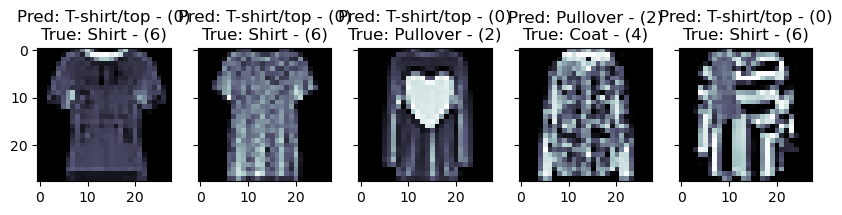

Predichos correctamente por el modelo: svm_fashion:


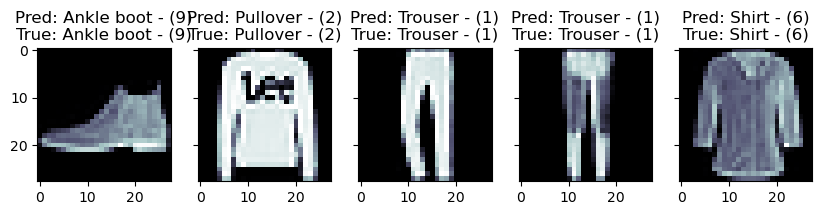

Evaluando tree_fashion (TREE)...
Accuracy del modelo: tree_fashion: 0.79
Predichos incorrectamente por el modelo: tree_fashion:


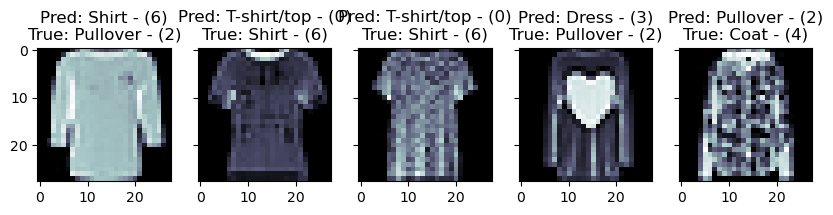

Predichos correctamente por el modelo: tree_fashion:


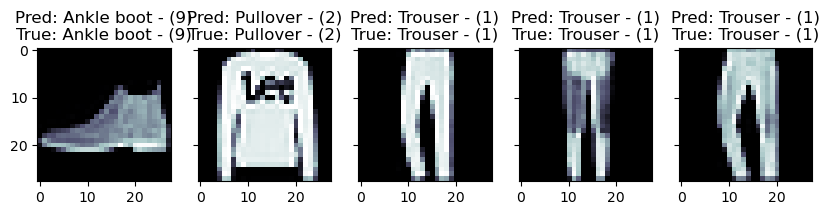

In [21]:
resultados_modelos = use_evaluate_model(models)

In [22]:
resultados_modelos

{'cnn_mnist': {'Mal predichos': Int64Index([9664, 9692, 9729, 9770, 9792, 9922], dtype='int64'),
  'Bien predichos': Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], dtype='int64')},
 'dnn_mnist': {'Mal predichos': Int64Index([9762, 9764, 9768, 9770, 9792, 9858], dtype='int64'),
  'Bien predichos': Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], dtype='int64')},
 'logreg_mnist': {'Mal predichos': Int64Index([9944, 9959, 9970, 9980, 9982, 9986], dtype='int64'),
  'Bien predichos': Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15], dtype='int64')},
 'mlp_mnist': {'Mal predichos': Int64Index([9768, 9770, 9792, 9839, 9904, 9982], dtype='int64'),
  'Bien predichos': Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], dtype='int64')},
 'rf_mnist': {'Mal predichos': Int64Index([9890, 9905, 9925, 9944, 9975, 9982], dtype='int64'),
  'Bien predichos': Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], dtype='int64')},
 'svm_mnist'

# Aplicación de Métodos Agnósticos para la Explicabilidad

Para aplicar técnicas de explicabilidad model-agnostic a los modelos entrenados (SVM, RF, MLPClassifier, DNN, CNN), comenzaré por integrar dos de las técnicas más populares y poderosas: LIME (Local Interpretable Model-agnostic Explanations) y SHAP (SHapley Additive exPlanations). Además, exploraré el uso de eli5, una biblioteca que proporciona formas de visualizar y entender las predicciones de los modelos. InterpretML (intercept-community) también puede ser útil dependiendo de las necesidades específicas de explicación y las características de los datos.

## Elección de Técnicas de Explicabilidad
* **LIME**: Permite explicar las predicciones de cualquier clasificador de manera que los humanos puedan entender, mostrando qué características de los datos contribuyen más a la predicción.
* **SHAP**: Utiliza valores de Shapley de la teoría de juegos para estimar cómo cada característica contribuye a la predicción, siendo útil para interpretar tanto modelos globales como predicciones individuales.
* **eli5**: Proporciona herramientas para visualizar y depurar modelos de machine learning y es compatible con muchos algoritmos de ML.
* **InterpretML** (Intercept-Community): Ofrece herramientas innovadoras para explicar modelos y es especialmente fuerte en modelos intrínsecamente interpretables.

### LIME



In [23]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import gray2rgb
from lime import lime_image
from skimage.segmentation import mark_boundaries

def explain_instance_with_lime(image, classifier_fn, name_model, val_pred, val_real, model_type='flat', labels=None, **kwargs):
    explainer = lime_image.LimeImageExplainer()

    # Acá lo que quiero hacer es convertir la imagen a RGB para que sea compatible con LIME
    image_rgb = gray2rgb(image.reshape(28, 28))

    # Acá lo que quiero hacer es adaptar la imagen para la predicción dependiendo del tipo de modelo
    def model_predict(data):
        if model_type == 'flat':
            x_flat = data[:, :, :, 0].reshape(-1, 28 * 28)  # Aplanar las imágenes para modelos de scikit-learn
        else:
            x_flat = data[:, :, :, 0].reshape(-1, 28, 28, 1)  # Mantener formato de imagen para CNN

        return classifier_fn(x_flat)

    # Acá lo que quiero hacer es explicar la instancia usando LIME y mostrar la imagen original
    plt.figure(figsize=(9, 3))
    plt.subplot(1, 3, 1)
    plt.imshow(image_rgb)
    plt.title("Imagen Original")
    plt.axis('off')

    # Acá lo que quiero hacer es generar una explicación de LIME con solo las características positivas
    explanation = explainer.explain_instance(image_rgb, model_predict, top_labels=5, num_samples=50, **kwargs)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=True)
    plt.subplot(1, 3, 2)
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask), cmap='viridis')
    plt.title("Características Positivas")
    plt.axis('off')

    # Acá lo que quiero hacer es generar una explicación de LIME con todas las características
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=True)
    plt.subplot(1, 3, 3)
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask), cmap='viridis')
    plt.title("Todas las Características")
    plt.axis('off')
    
    # Acá lo que quiero hacer es agregar el título de la explicación de LIME
    if labels is None:
        plt.suptitle(f"Explicación de LIME para el Modelo: {name_model} - El modelo dice {val_pred} y es {val_real}")
    else:
        plt.suptitle(f"Explicación de LIME para el Modelo: {name_model} - El modelo dice {labels[val_pred]} y es {labels[val_real]}")
    plt.show()

    # Acá lo que quiero hacer es seleccionar la misma clase explicada en las figuras anteriores
    ind = explanation.top_labels[0]

    # Acá lo que quiero hacer es mapear cada peso de explicación al superpíxel correspondiente
    dict_heatmap = dict(explanation.local_exp[ind])
    heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

    # Acá lo que quiero hacer es mostrar el mapa de calor. La visualización tiene más sentido si se usa una barra de color simétrica.
    plt.figure(figsize=(4, 4))
    plt.imshow(heatmap, cmap='coolwarm', vmin=-heatmap.max(), vmax=heatmap.max())
    plt.colorbar()
    plt.title("Mapa de Calor de la Explicación")
    plt.axis('off')
    plt.show()


****************************************
Explicaciones de LIME Mal Predichos - Dataset: MNIST
****************************************


100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 6452.18it/s]


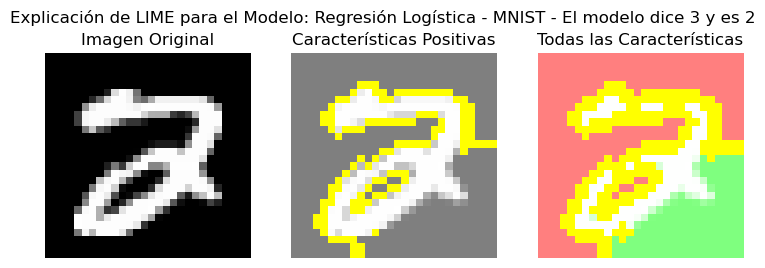

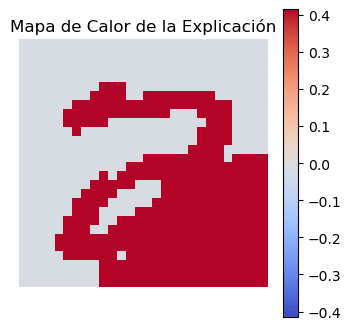

100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 5992.38it/s]


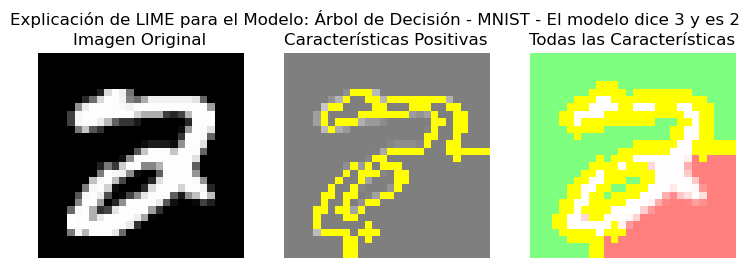

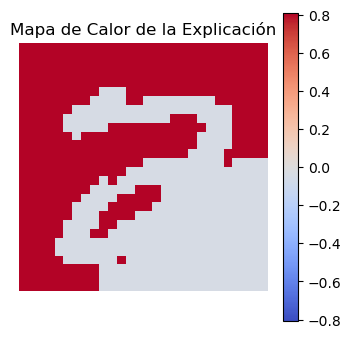

100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 179.99it/s]


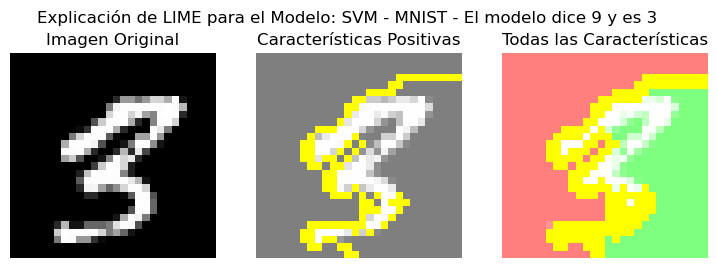

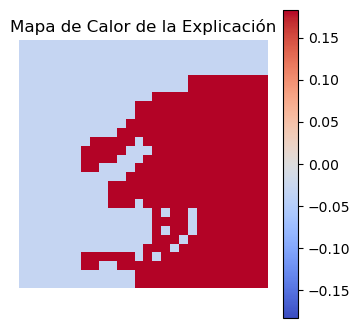

100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 987.28it/s]


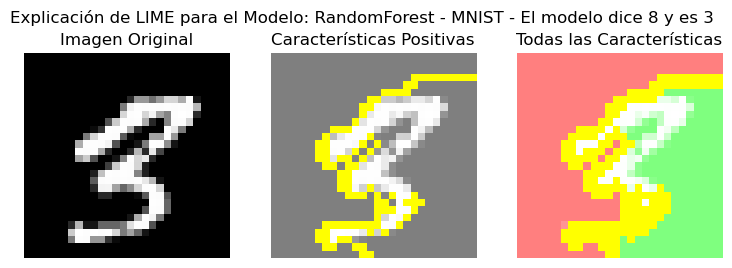

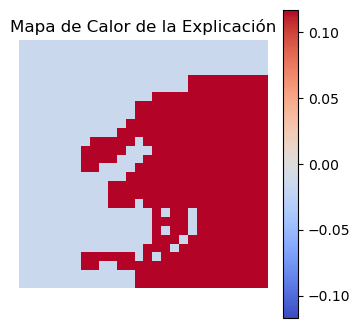

100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1195.97it/s]


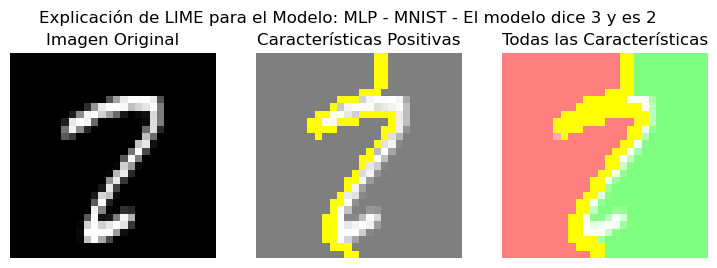

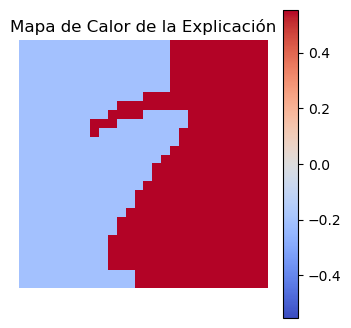

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


 20%|████████████████▍                                                                 | 10/50 [00:00<00:01, 20.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 40%|████████████████████████████████▊                                                 | 20/50 [00:00<00:00, 36.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 60%|█████████████████████████████████████████████████▏                                | 30/50 [00:00<00:00, 46.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [00:00<00:00, 56.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 48.66it/s]


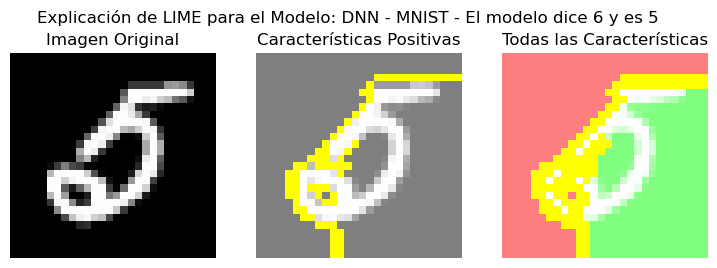

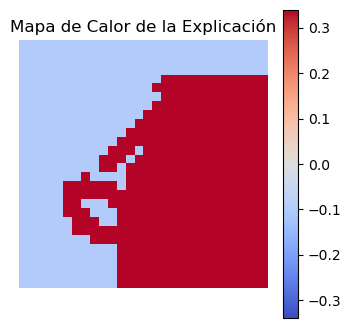

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 20%|████████████████▍                                                                 | 10/50 [00:00<00:00, 40.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 60%|█████████████████████████████████████████████████▏                                | 30/50 [00:00<00:00, 71.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [00:00<00:00, 77.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 74.01it/s]


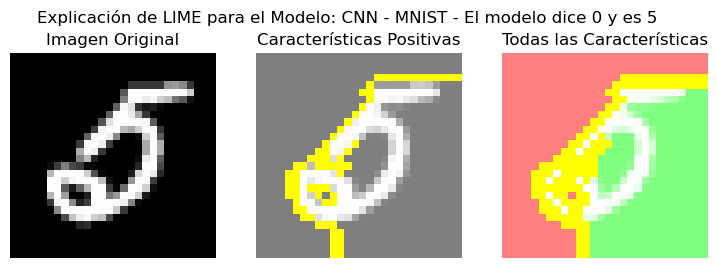

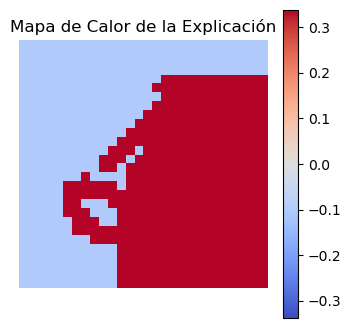

In [24]:
# Ejecutar para cada modelo
modelos = {
     'logreg_mnist': {'name':'Regresión Logística - MNIST','func': models['logreg_mnist'].predict_proba, 'type': 'flat'},
     'tree_mnist': {'name':'Árbol de Decisión - MNIST'  ,'func': models['tree_mnist'].predict_proba, 'type': 'flat'},
     'svm_mnist': {'name':'SVM - MNIST','func': models['svm_mnist'].predict_proba, 'type': 'flat'},
     'rf_mnist': {'name':'RandomForest - MNIST','func': models['rf_mnist'].predict_proba, 'type': 'flat'},
     'mlp_mnist': {'name':'MLP - MNIST','func': models['mlp_mnist'].predict_proba, 'type': 'flat'},  
     'dnn_mnist': {'name':'DNN - MNIST','func': models['dnn_mnist'].predict, 'type': 'flat'},
     'cnn_mnist': {'name':'CNN - MNIST','func': models['cnn_mnist'].predict, 'type': 'image'}   
}
print("*"*40)
print("Explicaciones de LIME Mal Predichos - Dataset: MNIST")
print("*"*40)

for name, model_info in modelos.items():
    id_imagen = resultados_modelos[name]['Mal predichos'][3]
    image_to_explain = x_test_mnist[id_imagen].reshape(28, 28)
    explain_instance_with_lime(image_to_explain, model_info['func'], model_info['name'],  predicciones[name][id_imagen],y_test_mnist[id_imagen], model_info['type'] )

****************************************
Explicaciones de LIME Bien Predichos - Dataset: MNIST
****************************************


100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 4566.77it/s]


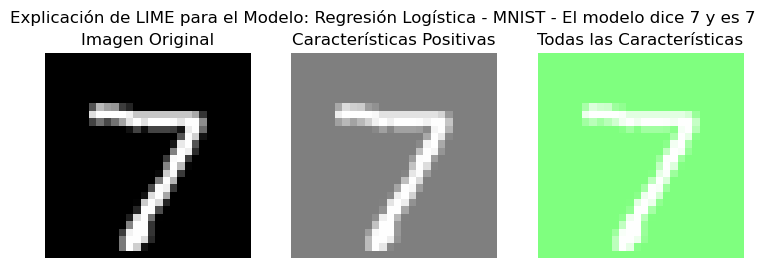

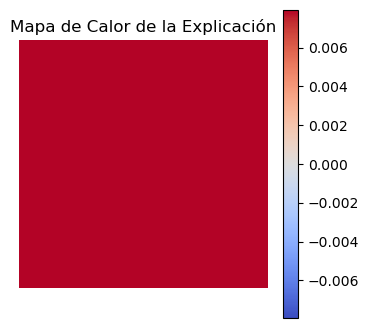

100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 5186.99it/s]


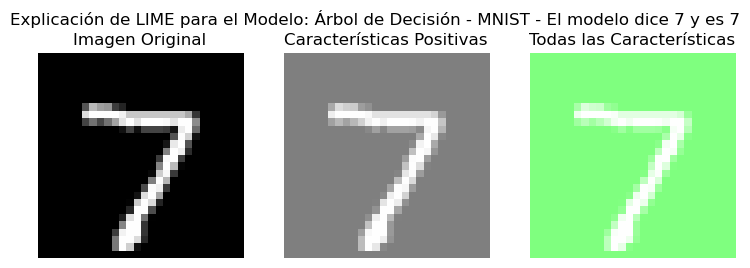

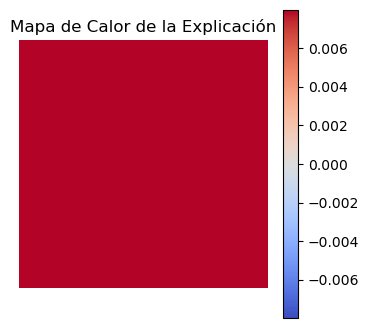

100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 171.08it/s]


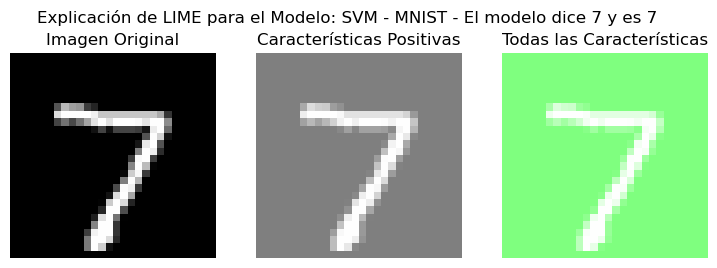

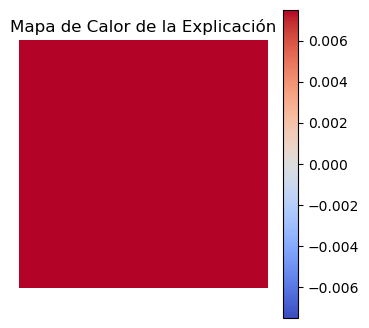

100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 961.76it/s]


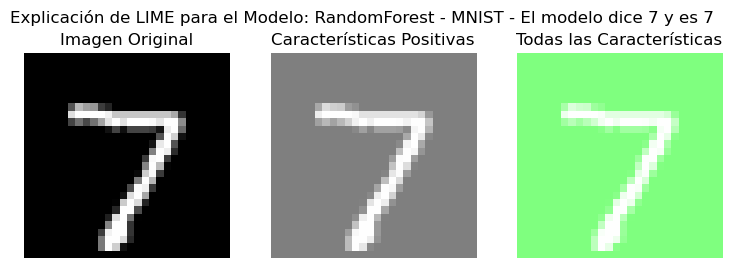

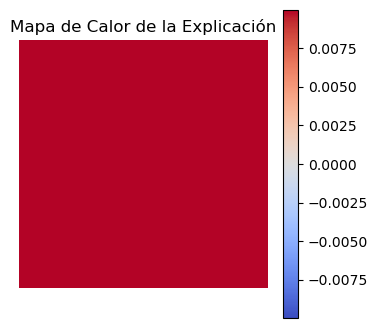

100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1162.70it/s]


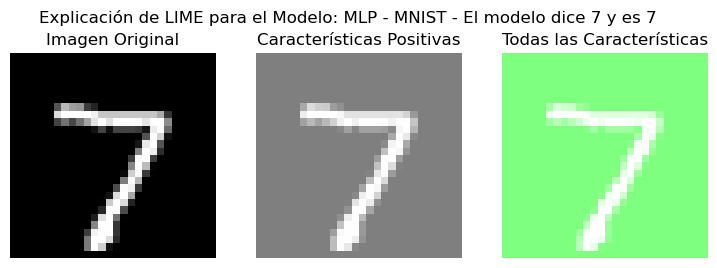

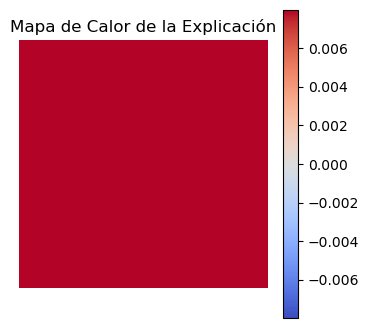

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 20%|████████████████▍                                                                 | 10/50 [00:00<00:00, 87.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 40%|████████████████████████████████▊                                                 | 20/50 [00:00<00:00, 92.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 60%|█████████████████████████████████████████████████▏                                | 30/50 [00:00<00:00, 94.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [00:00<00:00, 94.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 97.48it/s]


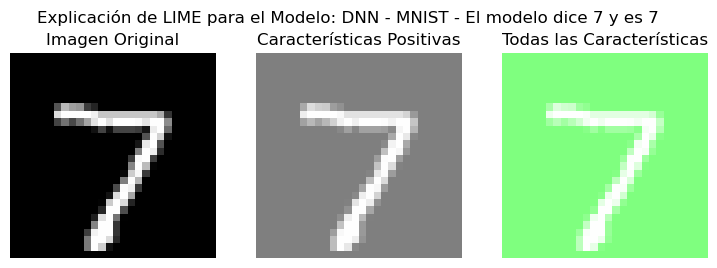

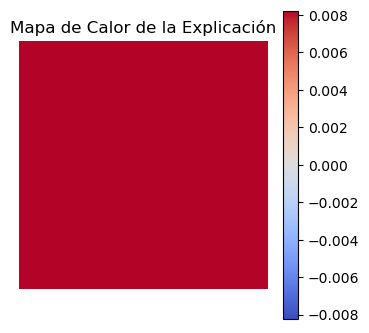

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 20%|████████████████▍                                                                 | 10/50 [00:00<00:00, 98.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 40%|████████████████████████████████▊                                                 | 20/50 [00:00<00:00, 94.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 60%|█████████████████████████████████████████████████▏                                | 30/50 [00:00<00:00, 93.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 101.06it/s]


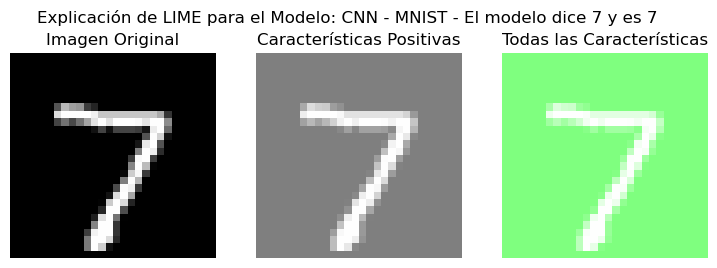

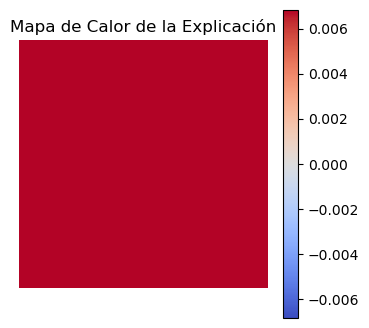

In [383]:
# Ejecutar para cada modelo
modelos = {
     'logreg_mnist': {'name':'Regresión Logística - MNIST','func': models['logreg_mnist'].predict_proba, 'type': 'flat'},
     'tree_mnist': {'name':'Árbol de Decisión - MNIST'  ,'func': models['tree_mnist'].predict_proba, 'type': 'flat'},
     'svm_mnist': {'name':'SVM - MNIST','func': models['svm_mnist'].predict_proba, 'type': 'flat'},
     'rf_mnist': {'name':'RandomForest - MNIST','func': models['rf_mnist'].predict_proba, 'type': 'flat'},
     'mlp_mnist': {'name':'MLP - MNIST','func': models['mlp_mnist'].predict_proba, 'type': 'flat'},  
     'dnn_mnist': {'name':'DNN - MNIST','func': models['dnn_mnist'].predict, 'type': 'flat'},
     'cnn_mnist': {'name':'CNN - MNIST','func': models['cnn_mnist'].predict, 'type': 'image'}   
}
print("*"*40)
print("Explicaciones de LIME Bien Predichos - Dataset: MNIST")
print("*"*40)

for name, model_info in modelos.items():
    id_imagen = resultados_modelos[name]['Bien predichos'][0]
    image_to_explain = x_test_mnist[id_imagen].reshape(28, 28)
    explain_instance_with_lime(image_to_explain, model_info['func'], model_info['name'],  predicciones[name][id_imagen],y_test_mnist[id_imagen], model_info['type'] )

****************************************
Explicaciones de LIME Mal Predichos - Dataset: Fashion MNIST
****************************************


100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 5406.15it/s]


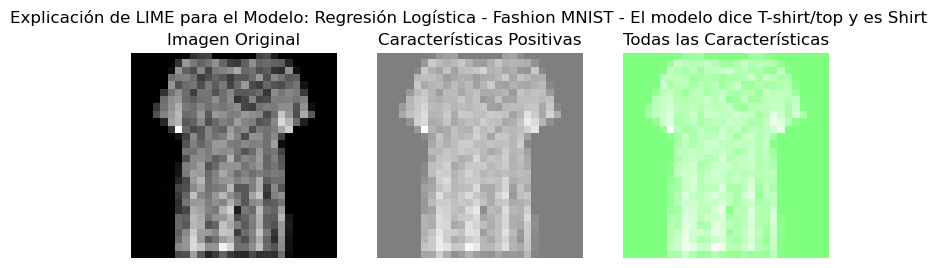

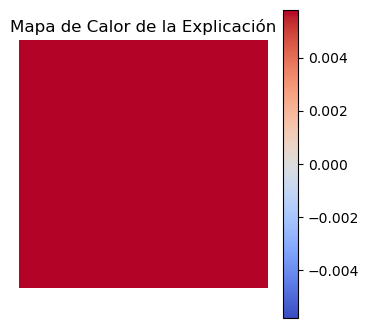

100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 6250.08it/s]


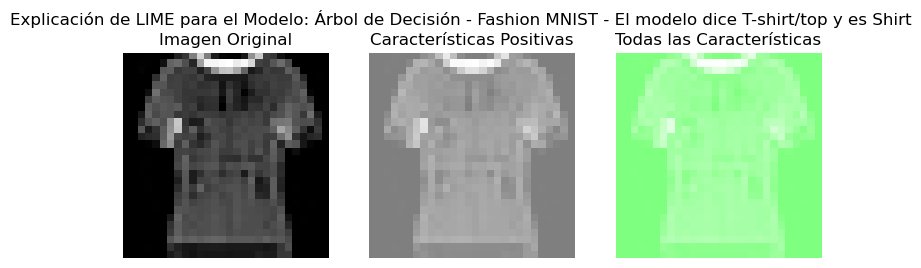

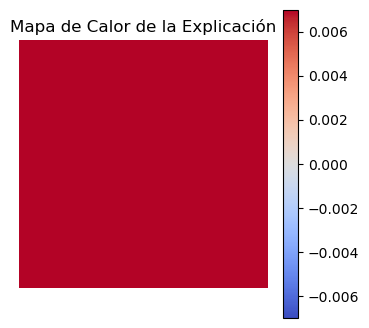

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 95.66it/s]


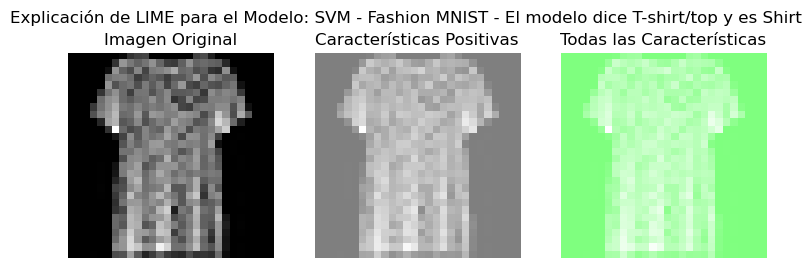

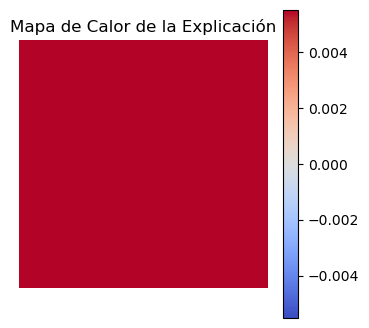

100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1035.19it/s]


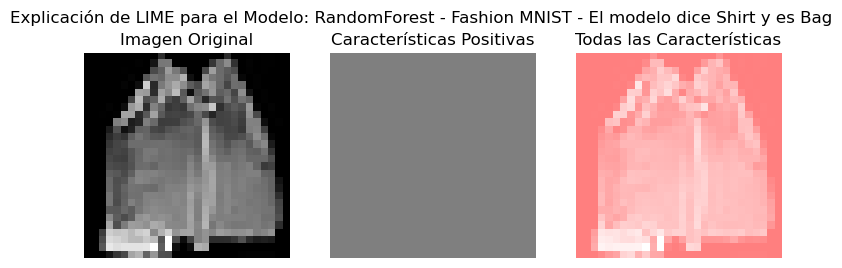

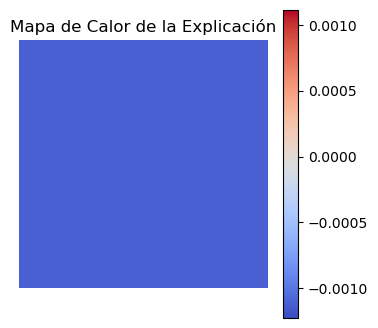

100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2179.90it/s]


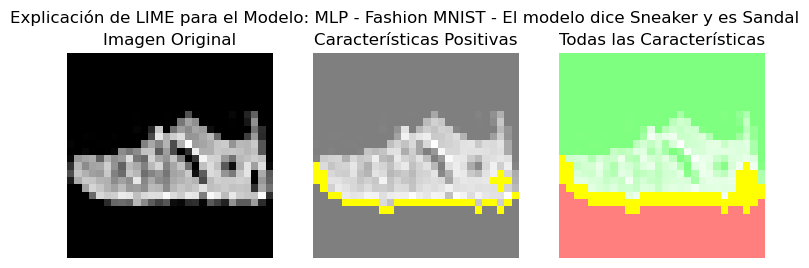

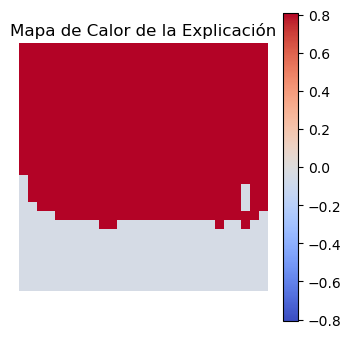

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 20%|████████████████▍                                                                 | 10/50 [00:00<00:00, 88.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


 40%|████████████████████████████████▊                                                 | 20/50 [00:00<00:00, 61.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 60%|█████████████████████████████████████████████████▏                                | 30/50 [00:00<00:00, 39.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [00:00<00:00, 47.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 54.73it/s]


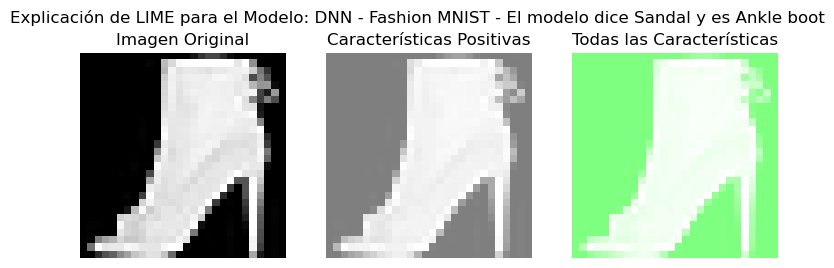

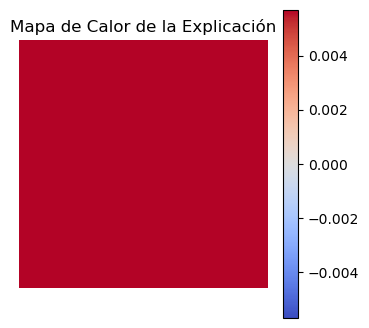

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 40%|████████████████████████████████▍                                                | 20/50 [00:00<00:00, 118.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 66%|█████████████████████████████████████████████████████▍                           | 33/50 [00:00<00:00, 123.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 111.30it/s]


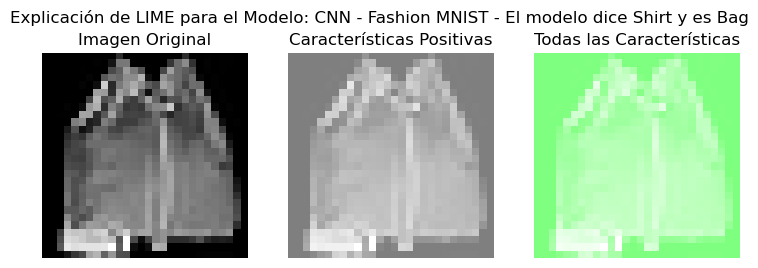

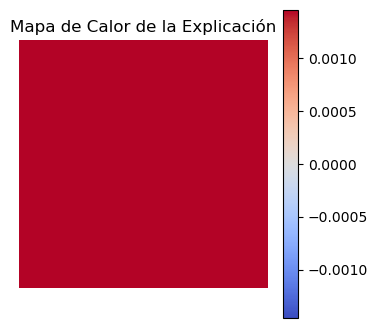

In [384]:

# Ejecutar para cada modelo
modelos = {
     'logreg_fashion': {'name':'Regresión Logística - Fashion MNIST','func': models['logreg_fashion'].predict_proba, 'type': 'flat'},
     'tree_fashion': {'name':'Árbol de Decisión - Fashion MNIST'  ,'func': models['tree_fashion'].predict_proba, 'type': 'flat'},
     'svm_fashion': {'name':'SVM - Fashion MNIST','func': models['svm_fashion'].predict_proba, 'type': 'flat'},
     'rf_fashion': {'name':'RandomForest - Fashion MNIST','func': models['rf_fashion'].predict_proba, 'type': 'flat'},
     'mlp_fashion': {'name':'MLP - Fashion MNIST','func': models['mlp_fashion'].predict_proba, 'type': 'flat'},  
     'dnn_fashion': {'name':'DNN - Fashion MNIST','func': models['dnn_fashion'].predict, 'type': 'flat'},
     'cnn_fashion': {'name':'CNN - Fashion MNIST','func': models['cnn_fashion'].predict, 'type': 'image'}   
}
print("*"*40)
print("Explicaciones de LIME Mal Predichos - Dataset: Fashion MNIST")
print("*"*40)

for name, model_info in modelos.items():
    id_imagen = resultados_modelos[name]['Mal predichos'][1]
    image_to_explain = x_test_fashion[id_imagen].reshape(28, 28)
    explain_instance_with_lime(image_to_explain, model_info['func'], model_info['name'],  predicciones[name][id_imagen],y_test_fashion[id_imagen], model_info['type'] ,fashion_mnist_labels)



****************************************
Explicaciones de LIME Bien Predichos - Dataset: Fashion MNIST
****************************************


100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 4545.29it/s]


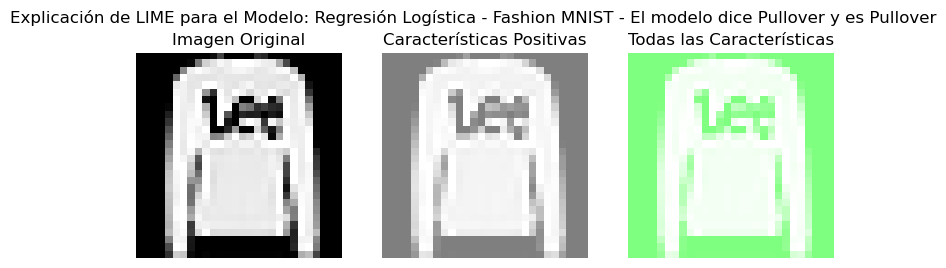

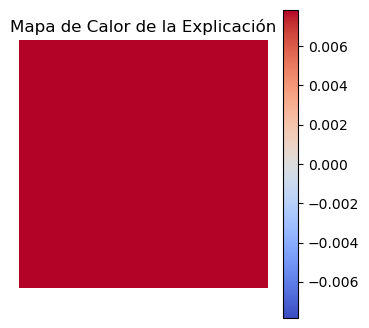

100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 4166.06it/s]


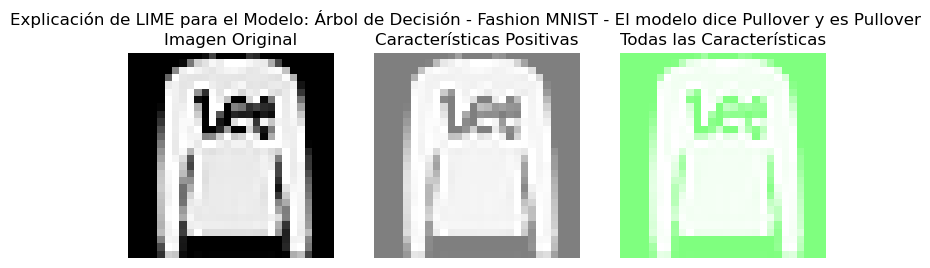

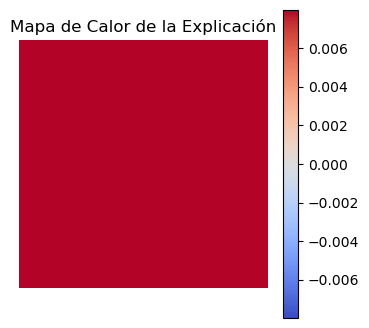

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 89.54it/s]


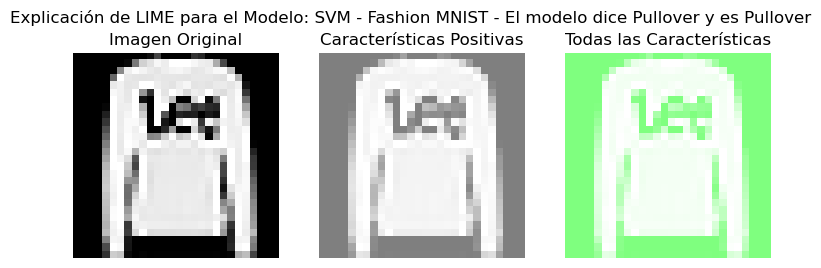

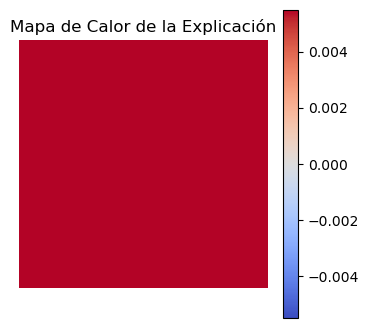

100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1030.05it/s]


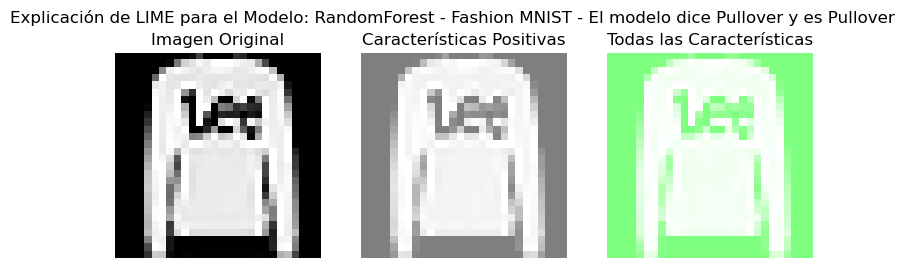

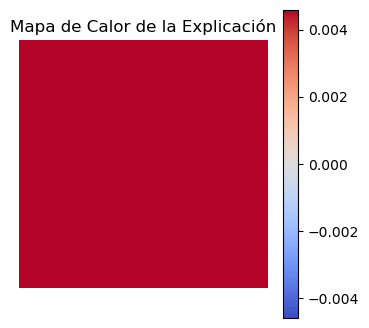

100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1604.41it/s]


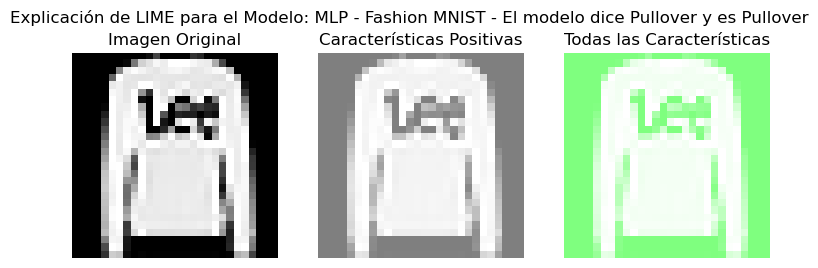

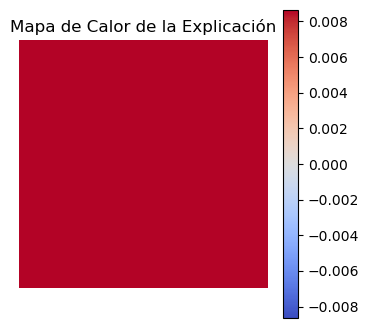

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 20%|████████████████▍                                                                 | 10/50 [00:00<00:00, 98.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 60%|████████████████████████████████████████████████▌                                | 30/50 [00:00<00:00, 101.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [00:00<00:00, 97.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 72.45it/s]


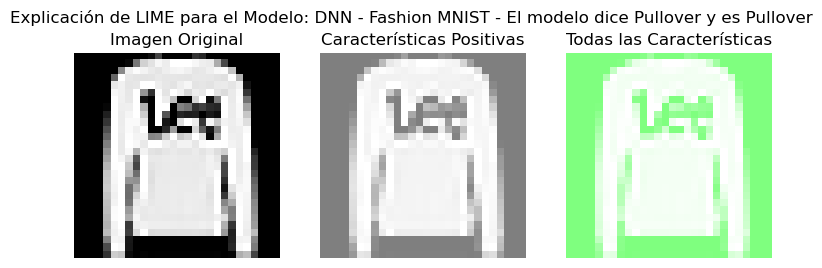

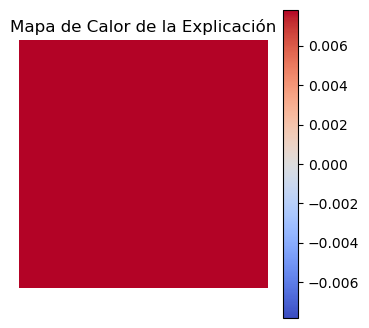

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 20%|████████████████▍                                                                 | 10/50 [00:00<00:00, 52.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 40%|████████████████████████████████▊                                                 | 20/50 [00:00<00:00, 56.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 60%|█████████████████████████████████████████████████▏                                | 30/50 [00:00<00:00, 57.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [00:00<00:00, 59.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 57.74it/s]


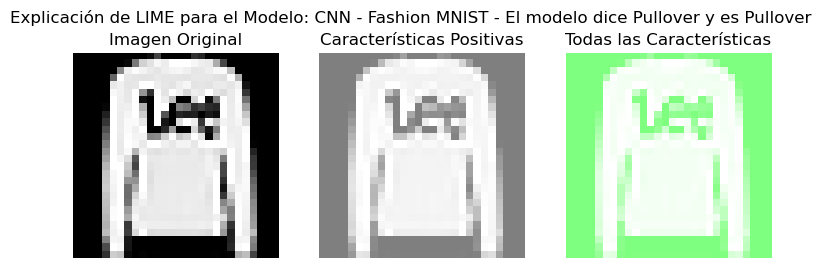

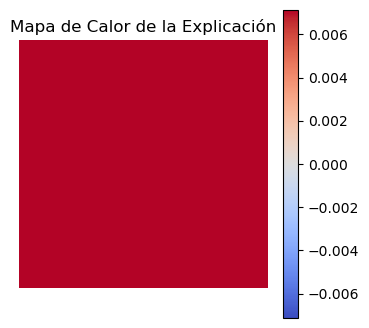

In [385]:

# Ejecutar para cada modelo
modelos = {
     'logreg_fashion': {'name':'Regresión Logística - Fashion MNIST','func': models['logreg_fashion'].predict_proba, 'type': 'flat'},
     'tree_fashion': {'name':'Árbol de Decisión - Fashion MNIST'  ,'func': models['tree_fashion'].predict_proba, 'type': 'flat'},
     'svm_fashion': {'name':'SVM - Fashion MNIST','func': models['svm_fashion'].predict_proba, 'type': 'flat'},
     'rf_fashion': {'name':'RandomForest - Fashion MNIST','func': models['rf_fashion'].predict_proba, 'type': 'flat'},
     'mlp_fashion': {'name':'MLP - Fashion MNIST','func': models['mlp_fashion'].predict_proba, 'type': 'flat'},  
     'dnn_fashion': {'name':'DNN - Fashion MNIST','func': models['dnn_fashion'].predict, 'type': 'flat'},
     'cnn_fashion': {'name':'CNN - Fashion MNIST','func': models['cnn_fashion'].predict, 'type': 'image'}   
}
print("*"*40)
print("Explicaciones de LIME Bien Predichos - Dataset: Fashion MNIST")
print("*"*40)

for name, model_info in modelos.items():
    id_imagen = resultados_modelos[name]['Bien predichos'][1]
    image_to_explain = x_test_fashion[id_imagen].reshape(28, 28)
    explain_instance_with_lime(image_to_explain, model_info['func'], model_info['name'],  predicciones[name][id_imagen],y_test_fashion[id_imagen], model_info['type'] ,fashion_mnist_labels)


### SHAP

In [86]:
#Calculates the SHAP value.
id_imagen = resultados_modelos['tree_mnist']['Mal predichos'][1]
imagen = x_test_mnist_flat[id_imagen]
input_data = imagen.flatten().reshape(1, -1)
explainer = shap.TreeExplainer(models['tree_mnist'])

shap_values = explainer.shap_values(input_data)

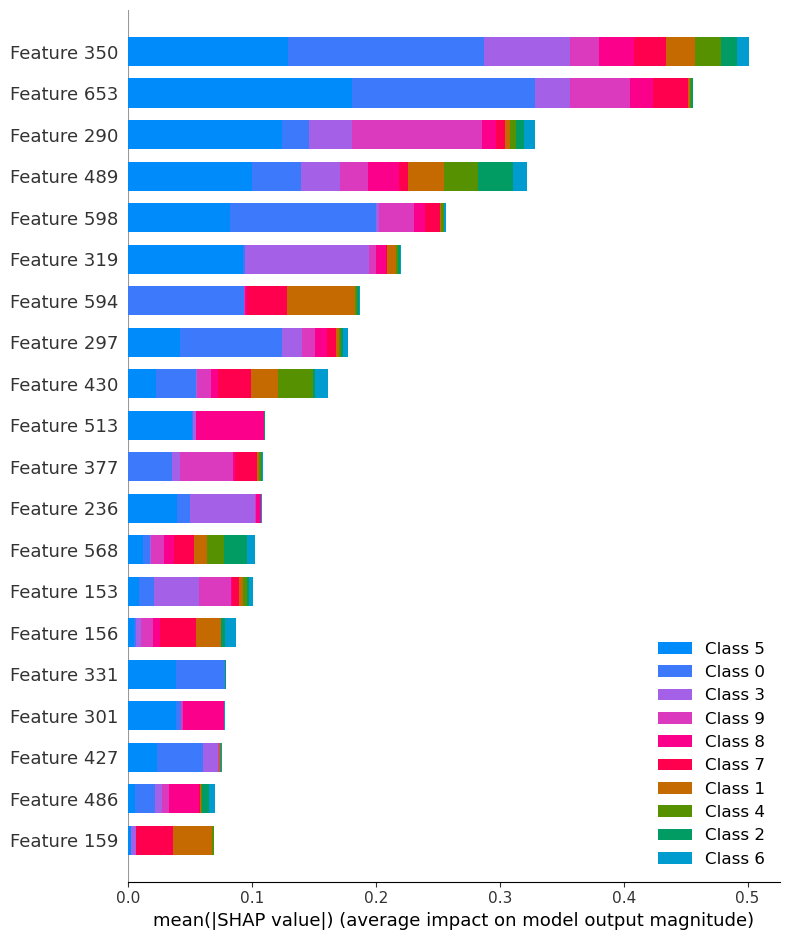

In [29]:
# Debugging: Check SHAP values

shap.summary_plot(shap_values, input_data, plot_type="bar")

El modelo predice: 2 y realmente es 3


This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


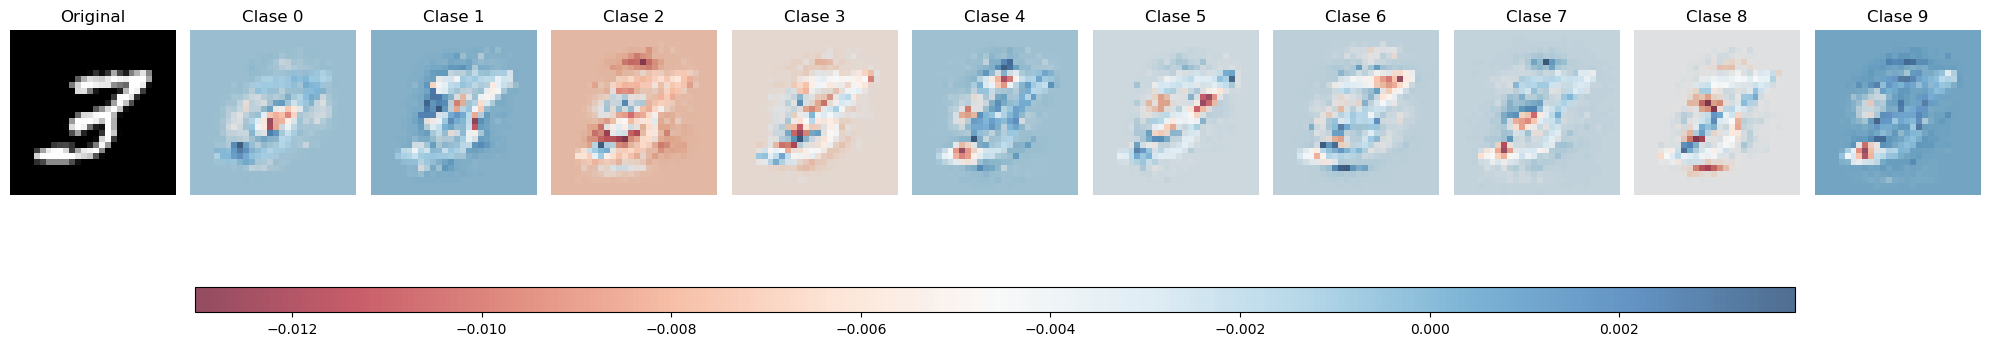

In [88]:
import shap
import matplotlib.pyplot as plt
import numpy as np

# Carga de la imagen y preparación de los datos de entrada
id_imagen = resultados_modelos['rf_mnist']['Mal predichos'][2]
imagen = x_test_mnist_flat[id_imagen]
input_data = imagen.flatten().reshape(1, -1)

# Cálculo de los valores SHAP
explainer = shap.TreeExplainer(models['rf_mnist'])
shap_values = explainer.shap_values(input_data)

# Convertimos los valores SHAP y los datos de entrada en la forma apropiada para image_plot
# shap_values es una lista de 10 arrays, uno por clase
shap_values_images = [sv.reshape(28, 28) for sv in shap_values]
input_image = input_data.reshape(28, 28)


# Configuración de la figura con subplots
fig, axes = plt.subplots(1, 11, figsize=(20, 5))
print(f"El modelo predice: {predicciones['rf_mnist'][id_imagen]} y realmente es {y_test_mnist[id_imagen]}")

# Mostrar la imagen original
axes[0].imshow(input_image, cmap='gray')
axes[0].set_title('Original')
axes[0].axis('off')

# Mostrar las imágenes con los valores SHAP utilizando el colormap 'RdBu'
for i in range(10):
    # Mostrar la imagen original en el fondo con transparencia
    axes[i + 1].imshow(input_image, cmap='gray', alpha=0.3)
    # Mostrar la imagen SHAP encima
    im = axes[i + 1].imshow(shap_values_images[i], cmap='RdBu', alpha=0.7)
    axes[i + 1].set_title(f'Clase {i}')
    axes[i + 1].axis('off')

# Agregar una barra de color
cbar_ax = fig.add_axes([0.1, 0.1, 0.8, 0.05])
fig.colorbar(im, cax=cbar_ax, orientation='horizontal')

plt.tight_layout()
plt.show()


In [ ]:
import shap
import matplotlib.pyplot as plt
import numpy as np

# Carga de la imagen y preparación de los datos de entrada
id_imagen = resultados_modelos['tree_mnist']['Mal predichos'][1]
imagen = x_test_mnist_flat[id_imagen]
input_data = imagen.reshape(28, 28, 1)  # Asegúrate de que input_data esté en formato 3D (28, 28, 1)

# Cálculo de los valores SHAP
explainer = shap.TreeExplainer(models['tree_mnist'])
shap_values = explainer.shap_values(input_data.reshape(1, -1))  # Asegúrate de que input_data esté en formato 2D (1, 784)

# Verificación de la predicción y del valor real
predicted_label = predicciones['tree_mnist'][id_imagen]
true_label = y_test_mnist[id_imagen]
print(f"El modelo predice: {predicted_label} y realmente es {true_label}")

# Preparar index_names
test_labels_errors = models['tree_mnist'].predict_proba(x_test_mnist_flat)
i = id_imagen  # Índice de la imagen mal predicha

index_names = np.array([str(x) + "\n" + '{:>7.2%}'.format(test_labels_errors[i][x]) for x in range(10)]).reshape(1, 10)
print("Predicted label: {}\nTrue label: {}".format(predicted_label, true_label))
print(index_names)

# Visualización de los resultados
shap.image_plot(shap_values, input_data)

# Agregar una barra de color
plt.colorbar(plt.cm.ScalarMappable(cmap='RdBu'), orientation='horizontal', pad=0.1, aspect=50)
plt.show()


El modelo predice: 5 y realmente es 0
Predicted label: 5
True label: 0
[['0\n  0.00%' '1\n  0.00%' '2\n  0.00%' '3\n  0.00%' '4\n  0.00%'
  '5\n100.00%' '6\n  0.00%' '7\n  0.00%' '8\n  0.00%' '9\n  0.00%']]


In [394]:
import shap
import numpy as np
import matplotlib.pyplot as plt

def explain_with_shap(image, model, name_model, model_type='flat'):
    if model_type == 'image':
        input_data = image.reshape(1, 28, 28, 1)
    else:
        input_data = image.flatten().reshape(1, -1)
    
    if 'tree' in str(type(model)).lower():
        explainer = shap.TreeExplainer(model)
    elif 'keras' in str(type(model)).lower() or 'tensorflow' in str(type(model)).lower():
        explainer = shap.DeepExplainer(model, input_data)
    else:
        background = shap.kmeans(input_data, 10)
        explainer = shap.KernelExplainer(model.predict, background)

    shap_values = explainer.shap_values(input_data)

    # Debugging: Check SHAP values
    print("SHAP values:", shap_values)

    if model_type == 'image':
        shap.image_plot(shap_values, input_data)
    else:
        shap.summary_plot(shap_values, input_data, plot_type="bar")

# Ejemplo de uso
image_to_explain = x_train_mnist_flat[10].reshape(28, 28)

modelos = {
    'Regresión Logística - MNIST': {'func': models['svm_mnist'], 'type': 'flat'},
    # Añadir más modelos según la necesidad
}

for name, model_info in modelos.items():
    explain_with_shap(image_to_explain, model_info['func'], name, model_info['type'])


ValueError: n_samples=1 should be >= n_clusters=10.

****************************************
Explicaciones de SHAP - Dataset: MNIST
****************************************


TypeError: Invalid shape (784,) for image data

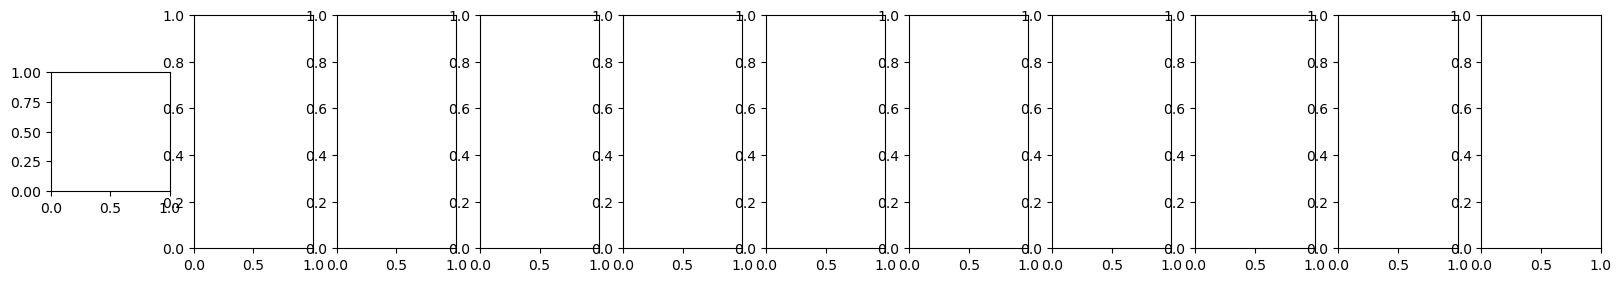

In [89]:
# Imagen a explicar
image_to_explain = x_train_mnist_flat[10].reshape(28, 28)

# Ejecutar para cada modelo
modelos = {
    # 'Regresión Logística - MNIST': {'func': models['log_reg_mnist'], 'type': 'flat'},
    'Árbol de Decisión - MNIST': {'func': models['tree_mnist'], 'type': 'flat'},
    'SVM - MNIST': {'func': models['svm_mnist'], 'type': 'flat'},
    'RandomForest - MNIST': {'func': models['rf_mnist'], 'type': 'flat'},
    'MLP - MNIST': {'func': models['mlp_mnist'], 'type': 'flat'},
    'DNN - MNIST': {'func': models['dnn_mnist'], 'type': 'image'},
    'CNN - MNIST': {'func': models['cnn_mnist'], 'type': 'image'}
}

print("*"*40)
print("Explicaciones de SHAP - Dataset: MNIST")
print("*"*40)

for name, model_info in modelos.items():
    explain_with_shap(image_to_explain, model_info['func'], name, model_info['type'])